In [92]:
# import library
import pickle, os
import pandas as pd
import numpy as np
import tqdm.notebook as tqdm
import copy
from scipy.stats.mstats import winsorize
from statsmodels.formula.api import ols

os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수')
# # Data Download
with open('FS_손익계산서보정본', 'rb') as f:
    data = pickle.load(f)

with open('Final_FS_ind', 'rb') as f:
    ind = pickle.load(f)

# 특정 자산만 뽑아서 csv로 정리하기
def get_item(concept_id):
    item = []
    item_ind = []
    # check id's address
    id_address = None
    for i in range(len(data)):
        for j in range(3):
            try:
                if concept_id in data[i][j].iloc[:,0].values:
                    id_address = j
            except AttributeError:
                pass
        if id_address != None:
            break
            
    for i in range(len(data)):
        if type(data[i][id_address]) == type(data[0][id_address]):
            item.append(data[i][id_address][data[i][id_address][data[i][id_address].columns[0]] == concept_id].iloc[:1])
            if len(data[i][id_address][data[i][id_address][data[i][id_address].columns[0]] == concept_id]) > 0:
                item_ind.append(ind[i])
    df_item = pd.concat(item)
    date = list(filter(lambda x: x[1] == ('연결재무제표',), df_item.columns))
    if id_address ==0:
        date_clean = list(map(lambda x: x[0], df_item[date].columns))
        df_item[date].columns = date_clean
        df_item2 = df_item[date]
        df_item2.columns = date_clean
        date_shifted = list(map(lambda x: shift_q(x), date_clean))
        df_item3 = df_item2
        df_item3.columns = date_shifted
        df_item4 = df_item3.groupby(level=0, axis=1).last()
        df_item3 = df_item4
        date_shifted2 = list(map(lambda x: shift_d(x), df_item4.columns))
        df_item3.columns = date_shifted2
        df_item5 = df_item3.groupby(level=0, axis=1).last()
        corp_code = list(map(lambda x:x[2], item_ind))
        df_item5['corp_code'] = corp_code
        df_item5 = df_item5.set_index('corp_code')
    else:
        date_clean = list(map(lambda x: x[0], df_item[date].columns))
        df_item[date].columns = date_clean
        df_item2 = df_item[date]
        df_item2.columns = date_clean
        date_shifted = list(map(lambda x: shift_flow_date(x), date_clean))
        df_item2.columns = date_shifted
        df_item3 = df_item2.groupby(level=0, axis=1).last()
        corp_code = list(map(lambda x:x[2], item_ind))
        df_item3['corp_code'] = corp_code
        df_item3 = df_item3.set_index('corp_code')
        df_item5 = df_item3
    return df_item5

def shift_q(date):
    if date[4:6]=='01' or date[4:6]=='02' or date[4:6]=='03':
        date = date[:4] + '0331'
    elif date[4:6]=='04' or date[4:6]=='05' or date[4:6]=='06':
        date = date[:4] + '0630'
    elif date[4:6]=='07' or date[4:6]=='08' or date[4:6]=='09':
        date = date[:4] + '0930'
    elif date[4:6]=='10' or date[4:6]=='11' or date[4:6]=='12':
        date = date[:4] + '1231'
    return date

def shift_d(date):
    # 케이스 두개 밖에 안되니까 그냥 수동으로 따져주자.
    if date[6:]=='01':
        date = date[:6] + '31'
    elif date[6:]=='29':
        date = date[:6] + '30'
    return date

def shift_flow_date(date):
    # 우선은 연간 데이터만 활용하도록 만들어놓아도 될 듯? 나중에 분기별로 뽑을 수 있는 옵션을 추가해야 할 것 같다.
    if date[4:6]=='01' and date[-4:-2]=='12':
        date = date[-8:-2] + '31'
    else:
        date = None
    return date

def get_item_on_date(item, date):
    return get_item(item)[date]

def get_item_for_period(item, date_from, date_to, term = 'Y'):
    # term은 Y, H, Q의 세 가지 옵션으로, 연도별, 반기별, 분기별 데이터를 얻어올 수 있도록 하는 옵션이다.
    data = []
    item_data = get_item(item)
    if term == 'Y':
        num = int(date_to[:4]) - int(date_from[:4]) +1
        date_working = date_from
        for i in range(num):
            data.append(item_data[date_working])
            date_working = date_working[:2] + str(int(date_working[2:4]) + 1) + date_working[4:]
            
    elif term == 'H':
        num = int((int(date_to[:4]) - int(date_from[:4])) * 2 + (int(date_to[4:6]) - int(date_from[4:6]))/6 + 1)
        date_working = date_from
        for i in range(num):
            try:
                data.append(item_data[date_working])
            except:
                try:
                    date_working = date_working[:6] + str(61 - int(date_working[6:]))
                    data.append(item_data[date_working])
                except KeyError:
                    print('해당 날짜의 데이터가 없습니다:', date_working)
            if int(date_working[4:6])+6 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0'+ str(int(date_working[4:6])-6)+'31'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 6).zfill(2) + '31'
                
    else:
        num = int((int(date_to[:4]) - int(date_from[:4])) * 4 + (int(date_to[4:6]) - int(date_from[4:6]))/3 + 1)
        date_working = date_from
        for i in range(num):
            try:
                data.append(item_data[date_working])
            except:
                try:
                    date_working = date_working[:6] + str(61 - int(date_working[6:]))
                    data.append(item_data[date_working])
                except KeyError:
                    print('해당 날짜의 데이터가 없습니다:', date_working)
            if int(date_working[4:6])+3 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0331'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 3).zfill(2) + '31'
                
    data = pd.concat(data, axis = 1)
    return data

os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수\\KRX_price')
def get_market_data_on_date(date, print_error = True):
    # 에러 메시지를 출력하고 싶지 않으면 print_error를 False로 설정
    try:
        data = pd.read_csv(date[2:4] + '_' + str(int(date[4:6])) + '_' + str(int(date[6:8])) + '.csv', encoding = 'cp949')
        data['종목코드'] = data['종목코드'].map(lambda x:str(x).zfill(6) if x != None else None)
        if data.isna()['종가'].sum() == len(data):
            raise FileNotFoundError
    except FileNotFoundError:
        if print_error:
            print('해당 날짜의 데이터가 존재하지 않습니다:', date)
        data = None
    return data

def get_market_cap_on_date(date, get_code = False):
    if get_code:
        data = get_market_data_on_date(date)[['종목코드','시장구분','시가총액']].set_index('종목코드')
        data.columns = [['시장구분','Market_Cap']]
    else:
        data = get_market_data_on_date(date)[['종목코드','시가총액']].set_index('종목코드')
        data.columns = [['Market_Cap']]
    data.index.rename('corp_code', inplace = True)
    return data

def last_market_date(date):
    # date의 기본형식은 'YYYYMM' : ex)'201212'. -> 'YYYYMMDD'도 가능하도록 코드 변경했음
    get_data = False
    day = 31
    while not get_data:
        if type(get_market_data_on_date(date[:6] + str(day), print_error = False)) != type(None):
            market_date = date[:6] + str(day)
            get_data = True
        else:
            day -=1
    return market_date

def find_next_market_date(date, today_opt = False):
    get_data = False
    if today_opt:
        market_date = pd.Timestamp(date)
    else:
        market_date = pd.Timestamp(date) + pd.Timedelta(days=1)
    while not get_data:
        if type(get_market_data_on_date(market_date.strftime('%Y%m%d'), print_error = False)) != type(None):
            get_data = True
        else:
            market_date += pd.Timedelta(days=1)
    
    return market_date.strftime('%Y%m%d')

def get_market_cap_for_period(date_from, date_to, term = 'Y', ind_match = True):
    # ind_match는 fundamental과 합치기 편하도록 실제 날짜가 아니라 월말 날짜를 표시하도록 하는 옵션
    data = []
    ind = []
    if term == 'Y':
        num = int(date_to[:4]) - int(date_from[:4]) +1
        date_working = date_from
        for i in range(num):
            data.append(get_market_cap_on_date(last_market_date(date_working), get_code = True))
            if ind_match:
                ind.append(date_working)
            else:
                ind.append(last_market_date(date_working))
            date_working = date_working[:2] + str(int(date_working[2:4]) + 1) + date_working[4:]
            
    elif term == 'H':
        num = int((int(date_to[:4]) - int(date_from[:4])) * 2 + (int(date_to[4:6]) - int(date_from[4:6]))/6 + 1)
        date_working = date_from
        for i in range(num):
            data.append(get_market_cap_on_date(last_market_date(date_working), get_code = True))
            if ind_match:
                ind.append(date_working)
            else:
                ind.append(last_market_date(date_working))
            if int(date_working[4:6])+6 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0'+ str(int(date_working[4:6])-6)+'31'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 6).zfill(2) + '31'
                
    else:
        num = int((int(date_to[:4]) - int(date_from[:4])) * 4 + (int(date_to[4:6]) - int(date_from[4:6]))/3 + 1)
        date_working = date_from
        for i in range(num):
            data.append(get_market_cap_on_date(last_market_date(date_working), get_code = True))
            if ind_match:
                ind.append(date_working)
            else:
                ind.append(last_market_date(date_working))
            if int(date_working[4:6])+3 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0331'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 3).zfill(2) + '31'
    cap_data = [x.iloc[:,1] for x in data]
    cat_data = [x.iloc[:,0] for x in data]
    cap_data = pd.concat(cap_data, axis =1)
    cap_data.columns = ind
    cat_data = pd.concat(cat_data, axis =1)
    cat_data.columns = ind
    return cap_data, cat_data

def get_market_category(data):
    market_cat = []
    for i in range(len(data.columns)):
        market_cat.append(get_market_cap_on_date(last_market_date(data.columns[i]), get_code = True).iloc[:,0])
    market_cat = pd.concat(market_cat, axis=1)
    market_cat.columns = data.columns
    return market_cat

def get_breakpoint(data, breakpoint):
    absolute_point = []
    rank = data.rank(pct=True)
    for i in range(len(breakpoint)):
        absolute_point.append((data[rank < breakpoint[i]].max() + data[rank > breakpoint[i]].min())/2)
    return absolute_point

def get_mask(data, market_cat = None, market_bp = 'All', breakpoint: list = [0.5]):
    # data는 mask의 기준이 되는 baseline data
    # market_bp는 'ALL', 'KOSPI', 'KOSDAQ'으로, 기준이 되는 breakpoint의 market을 의미
    # breakpoint는 masking의 구분점으로, list안에 float이 담긴 형태를 받음
    breakpoint = np.sort(breakpoint)
    mask_list = []
    
    data_ind = data.index
    if type(market_cat) != type(None):
        market_cat = market_cat[market_cat.index.map(lambda x: x in data.index)]
        for i in range(len(data)):
            if data_ind[i] not in market_cat.index:
                market_cat.loc[data_ind[i]] = None
        market_cat = market_cat.reindex(index = data.index)
    for i in range(len(data.columns)):
        mask = data.iloc[:,i] * 0 +1
        mask_np = -np.ones(len(mask))
        #rank = data.iloc[:,i].rank(pct = True)
        if market_bp == 'All':
            absolute_point = get_breakpoint(data.iloc[:,i], breakpoint)
        if market_bp == 'KOSPI':
            absolute_point = get_breakpoint(data[market_cat.iloc[:,i]=='KOSPI'].iloc[:,i], breakpoint)
        if market_bp == 'KOSDAQ':
            absolute_point = get_breakpoint(data[market_cat.iloc[:,i]=='KOSDAQ'].iloc[:,i], breakpoint)
        for j in range(len(breakpoint)+1):
            if j < len(breakpoint):
                for k in range(len(mask)):
                    mask_np[k] = j if data.iloc[k,i] < absolute_point[j] and mask_np[k] == -1 else mask_np[k]
            else:
                for k in range(len(mask)):
                    mask_np[k] = j if data.iloc[k,i] > absolute_point[j-1] and mask_np[k] == -1 else mask_np[k]
        mask = mask * mask_np
        mask_list.append(mask)
    mask_df = pd.concat(mask_list, axis =1)
    return mask_df

def shift_date_quarter(data, num_of_quarters):
    # data의 date를 원하는 만큼 밀어줌.
    dates = data.columns
    years = [int(x[:4]) for x in dates]
    months = [int(x[4:6]) for x in dates]
    shifted_months = [x + num_of_quarters * 3 for x in months]
    shifted_years = [x + (shifted_months[i]-1) // 12 for i, x in enumerate(years)]
    shifted_months = [(x -1) % 12 +1 for x in shifted_months]
    dates = [str(shifted_years[i]) + str(shifted_months[i]).zfill(2)+ '30' if shifted_months[i] in [6, 9] else str(shifted_years[i]) + str(shifted_months[i]).zfill(2)+ '31' for i in np.arange(len(years))]
    data2 = copy.deepcopy(data)
    data2.columns = dates
    return data2

In [93]:
def get_factor_on_date_by_mask(mask, term = 'd', winsorize_limits = 0.01, weight = 'EW'):
    # @@@@@@@@@@@ option 추가해야할듯! : daily / weekly / monthly / quarterly 정도까지는 구현을 해놓아야할듯
    # monthly 계산할 때 첫 달은 어떻게 계산하는거지? 전달 말일 기준으로 계산하나? 아니면 해당 달 시초가 기준으로 계산하나?
    # -> 우선 첫 달은 시가 기준, 이후로는 전달 말일에 리밸런싱 하는 걸 기준으로 계산했음. 
    term_conservative = pd.Timestamp(mask.columns[1]) - pd.Timestamp(mask.columns[0]) - pd.Timedelta(days = 7)
    if pd.Timestamp(mask.columns[-1]) + term_conservative >  pd.Timestamp('20210630'):
        date_to = pd.Timestamp('20210630')
    else:
        date_to = pd.Timestamp(last_market_date((pd.Timestamp(mask.columns[-1]) + term_conservative).strftime('%Y%m%d')))
    date_from = pd.Timestamp(mask.columns[0])
    factor_days = (date_to - date_from).days
    factor_months = (date_to.year - date_from.year)*12 + (date_to.month - date_from.month)
    
    date_point = date_from.strftime('%Y%m%d')
    # this is for storing the last date
    date_point_marked = None
    
    total_factor = []
    date_list = []
    
    if term == 'd':
        flag = -1
#         for _ in range(factor_days):
        for _ in tqdm.tqdm(range(10)):
            if pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
            date_point_marked = date_point
            first = get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_point = find_next_market_date(date_point_marked)
            second = get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_list.append(date_point)
            return_list = [[] for x in np.arange(mask.max()[0]+1)]
            value_list = [[] for x in np.arange(mask.max()[0]+1)]
            for i in range(len(first)):
                if first.iloc[i,0] in c_mask.index and c_mask.notna().loc[first.iloc[i,0]]:
                    if second.notna()[second['종목코드'] == first.iloc[i,0]].iloc[0,0]:
                        return_list[int(c_mask.loc[first.iloc[i,0]])].append(second[second['종목코드'] == first.iloc[i,0]].iloc[0,3])
                    else:
                        return_list[int(c_mask.loc[first.iloc[i,0]])].append(-0.99)
                    value_list[int(c_mask.loc[first.iloc[i,0]])].append(first.iloc[i,2])
                    
            if weight == 'VW':
                for i in range(len(return_list)):
                    # len을 곱해준 건 나중에 mean에서 EW와 같은 형태로 들어가게 하도록 하기 위함.
                    return_list[i] *= value_list[i]/ np.sum(value_list[i]) * len(value_list[i])
                    
            # winsorize
            if winsorize_limits > 0:
                for i in range(len(return_list)):
                    return_list[i] = winsorize(return_list[i], limits = winsorize_limits)
                
            factor = [np.mean(x) for x in return_list]
            total_factor.append(factor)
        return pd.DataFrame(total_factor, index = date_list)
    elif term == 'm':
        flag = -1
        for _ in tqdm.tqdm(range(factor_months)):
            if flag +1 == mask.shape[1]:
                c_mask = mask.iloc[:,flag]
                date_point_marked = date_point
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '시가', '시가총액', '등락률']]).set_index('종목코드')
                c_mask = c_mask.loc[list(filter(lambda x: x in first.index, c_mask[c_mask.notna()].index))]
            elif pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
                date_point_marked = last_market_date(date_point)
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '시가', '시가총액', '등락률']]).set_index('종목코드')
                c_mask = c_mask.loc[list(filter(lambda x: x in first.index, c_mask[c_mask.notna()].index))]
            else:
                date_point_marked = date_point
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]).set_index('종목코드')
            
            # 통일된 수식으로 flag가 바뀐 경우의 말일을 계산할 수 있음
            date_point = last_market_date(find_next_market_date(date_point_marked))
            second = (get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]).set_index('종목코드')
            date_list.append(date_point[:6])
            return_value = get_market_return_for_period(date_point_marked, date_point)
            return_list = []
            value_list = []
            for i in range(int(mask.max()[0]+1)):
                return_list.append(return_value.loc[c_mask[c_mask == i].index].loc[:,['등락률']].values)
                value_list.append(return_value.loc[c_mask[c_mask == i].index].loc[:,['시가총액']].values)
            c_mask.drop(list(set(c_mask.index) - set(second.index)), inplace=True)
            if weight == 'VW':
                for i in range(len(return_list)):
                    # len을 곱해준 건 나중에 mean에서 EW와 같은 형태로 들어가게 하도록 하기 위함.
                    return_list[i] *= value_list[i]/ np.sum(value_list[i]) * len(value_list[i])
            # winsorize
            if winsorize_limits > 0:
                for i in range(len(return_list)):
                    return_list[i] = winsorize(return_list[i], limits = winsorize_limits)
            factor = [np.mean(x) for x in return_list]
            total_factor.append(factor)
        return pd.DataFrame(total_factor, index = date_list)

# Pfo Construction

In [94]:
def make_portfolio(pfo, factor, market_bp= 'All', breakpoint=[0.5]):
    # 여기서 앞에 들어가는 거는 마스크, 뒤에 들어가는 거는 실제값. 
    max_num = int(pfo.max()[0]+1)
    new_df = pd.DataFrame(index = pfo.index, columns = pfo.columns)
    for i in range(len(pfo.columns)):
        for j in range(max_num):
            get_index = list(filter(lambda x: x in factor.index, pfo.iloc[:,i][pfo.iloc[:,i]==j].index))
            pfo_mask = get_mask(pd.DataFrame(factor.loc[get_index].iloc[:,i]), get_market_category(pd.DataFrame(factor.loc[get_index].iloc[:,i])), market_bp, breakpoint)
            new_df.iloc[:,i].loc[pfo_mask.index] = pfo_mask.values[:,0]
    return new_df

def serialize_pfo(mask_list: list):
    # 사전식 배열. 앞에서부터 사전식으로 serialize하여 뱉음
    serial_num = [x.max().max()+1 for x in mask_list]
    for i in reversed(range(len(serial_num)-1)):
        serial_num[i] *= serial_num[i+1]
    serial_num += [1]
    serial_num = serial_num[1:]
    serial_elem = [x * mask_list[i] for i, x in enumerate(serial_num)]
    for i in range(len(serial_elem)-1):
        serial_elem[0] += serial_elem[i+1]
    return serial_elem[0]

# Regression 해볼 수 있도록 만들기

In [95]:
def get_market_return_for_period(date_from, date_to):
    first = get_market_data_on_date(find_next_market_date(date_from, today_opt = True), print_error = False).loc[:, ['종목코드', '종가', '시가총액']].set_index('종목코드')
    df = pd.DataFrame()
    flag = find_next_market_date(date_from, today_opt = True)
    while flag != date_to:
        flag = find_next_market_date(flag)
        df = pd.concat([df, get_market_data_on_date(flag, print_error = False).loc[:,['종목코드', '등락률']].set_index('종목코드').rename({'등락률':flag}, axis=1)], axis=1)
        if flag == date_to:
            second = get_market_data_on_date(flag, print_error = False).loc[:, ['종목코드', '종가']].set_index('종목코드')
    df = df.applymap(lambda x: (100 + x)/100)
    for i in range(len(df.columns)):
        if i == 0:
            geo_sum = df.iloc[:,i].copy()
        else:
            geo_sum *= df.values[:,i]
    compute_by_price = second['종가'] / first['종가']
    # 가정 : 3% 이상 차이가 날 수 없다. 계산상 최대 1프로 정도 차이지만, 좀 갭을 두었음.
    final_return = (compute_by_price - geo_sum < 0.03) * compute_by_price + (compute_by_price - geo_sum >= 0.03) * geo_sum
    final_return = pd.concat([final_return.loc[first.index].fillna(0.01), first['시가총액']], axis=1).rename({0:'등락률'}, axis=1)
    final_return['등락률'] = final_return['등락률'] -1
    return final_return

In [96]:
def get_market_return(mask, term = 'd'):
    term_conservative = pd.Timestamp(mask.columns[1]) - pd.Timestamp(mask.columns[0]) - pd.Timedelta(days = 7)
    if pd.Timestamp(mask.columns[-1]) + term_conservative >  pd.Timestamp('20210630'):
        date_to = pd.Timestamp('20210630')
    else:
        date_to = pd.Timestamp(last_market_date((pd.Timestamp(mask.columns[-1]) + term_conservative).strftime('%Y%m%d')))
    date_from = pd.Timestamp(mask.columns[0])
    factor_days = (date_to - date_from).days
    factor_months = (date_to.year - date_from.year)*12 + (date_to.month - date_from.month)
    
    date_point = date_from.strftime('%Y%m%d')
    # this is for storing the last date
    date_point_marked = None
    
    total_return = []
    date_list = []
    
    if term == 'd':
        flag = -1
        date_point = find_next_market_date(date_point)
        for _ in tqdm.tqdm(range(factor_days)):
            if pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
            first = get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_list.append(date_point)
            date_point = find_next_market_date(date_point)
            
            market_cap = first['시가총액'].sum()
            R = first['등락률'] * (first['시가총액'] / market_cap)
            total_return.append(R.fillna(0).sum())
            
        return pd.DataFrame(total_return, index = date_list)
    elif term == 'm':
        flag = -1
        for _ in tqdm.tqdm(range(factor_months)):
            if flag +1 == mask.shape[1]:
                c_mask = mask.iloc[:,flag]
                date_point = find_next_market_date(date_point)
                date_point_marked = date_point
            elif pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
                date_point_marked = last_market_date(date_point)
            else:
                date_point_marked = date_point
            
            date_point = last_market_date(find_next_market_date(date_point_marked))
            return_value = get_market_return_for_period(date_point_marked, date_point)
            date_list.append(date_point[:6])
            market_cap = return_value['시가총액'].sum()
            R = return_value['등락률'] * (return_value['시가총액'] / market_cap)
            
            total_return.append(R.replace([np.inf, -np.inf], np.nan).fillna(0).sum())
        return pd.DataFrame(total_return, index = date_list)

In [6]:
# risk free rate
os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수')
cd_91 = pd.read_csv('cd금리.csv', encoding='cp949', header=2, index_col=0).T.iloc[:, [4]]
cd_91.index = cd_91.index.map(lambda x: x[:6])
cd_91.columns = ['cd_91']
os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수\\KRX_price')

# 모듈화하기

In [97]:
def get_risk_free_rate(pfo, risk_free):
    return risk_free.loc[pfo.index]

def get_ols_model(mask, R_m, pfo_column, risk_free, *args):
#     R_m = get_market_return(mask, term = 'm').squeeze()
    R_f = (get_risk_free_rate(pfo_column, risk_free).astype(float)/12).squeeze()
    df = pd.DataFrame([(pfo_column - R_f.T).values.squeeze(), (R_m - R_f).values.squeeze()] + [x.values.squeeze() for x in args]).T
    df.columns = ['pfo', 'market'] + ['factor' + str(i) for i, x in enumerate(args)]
    var_str = ''
    for i in range(len(df.columns)-2):
        var_str += ' + ' + ['factor' + str(i) for i, x in enumerate(args)][i]
    model = ols(formula = 'pfo ~ market' + var_str,data = df).fit()
    return model

# 이제 FF5 구현해보자. 

## FF5 model with 크롤링 데이터
- 2009년(CMA), 2010년(HML, RMW), 2011년(SMB) 데이터부터 써서 2011년 6월30일 종가 기준 리밸런싱이 처음. 
- 2018년(CMA), 2019년(HML, RMW), 2020년(SMB) 데이터까지 써서 2020년 6월30일 종가 기준 리밸런싱이 마지막.
- 따라서 regression의 기간은 2011년 7월 ~ 2021년 6월
- 상하위 1% winsorization
- (size/BEME), (size/OP), (size/INV)로 25포트폴리오에 대해 OLS분석
#### 차례
1. (size/BEME) 25포트폴리오에 대해 OLS분석     
    (1) Rm, SMB, HML, RMW, CMA로 regression       
    (2) HML를 다른 4개 팩터에 projection시켜서 HMLO로 대체     
            
2. (size/OP) 25포트폴리오에 대해 OLS분석     
    (1) Rm, SMB, HML, RMW, CMA로 regression       
    (2) HML를 다른 4개 팩터에 projection시켜서 HMLO로 대체      
             
3. (size/INV)로 25포트폴리오에 대해 OLS분석      
    (1) Rm, SMB, HML, RMW, CMA로 regression       
    (2) HML를 다른 4개 팩터에 projection시켜서 HMLO로 대체      
          
4. 블룸버그 데이터와의 비교 (우리 데이터가 괜찮음을 증명)      

In [8]:
Market_cap = get_market_cap_for_period('20101231', '20191231')

equity = get_item_for_period('ifrs_Equity', '20101231', '20191231')

BEME = equity/Market_cap[0]

C:\Users\jky93\Anaconda3\envs\python383\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
C:\Users\jky93\Anaconda3\envs\python383\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
C:\Users\jky93\Anaconda3\envs\python383\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

In [9]:
Market_cap = get_market_cap_for_period('20110630', '20200630')

In [98]:
# SMB
SMB_mask = get_mask(Market_cap[0], get_market_category(Market_cap[0]), market_bp = 'KOSPI')

SMB = get_factor_on_date_by_mask(SMB_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

  0%|          | 0/120 [00:00<?, ?it/s]

In [99]:
# HML
BEME_shifted = shift_date_quarter(BEME, 2)

HML_mask = get_mask(BEME_shifted, get_market_category(BEME_shifted), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])

HML = get_factor_on_date_by_mask(HML_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/387726260

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype expli

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype expli

  0%|          | 0/120 [00:00<?, ?it/s]

In [12]:
# RMW 계산하기
# (영업이익 - 이자비용) / 총자산
Total_asset = get_item_for_period('ifrs_Assets', '20101231', '20191231')
fcost1 = get_item_for_period('ifrs_FinanceCosts', '20101231', '20191231')
fcost2 = get_item_for_period('dart_InterestExpenseFinanceExpense', '20101231', '20191231')
fcost = pd.concat([fcost1, fcost2], axis = 1).groupby(level=0, axis=1).last()
OI = get_item_for_period('dart_OperatingIncomeLoss', '20101231', '20191231')

C:\Users\jky93\Anaconda3\envs\python383\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
C:\Users\jky93\Anaconda3\envs\python383\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
C:\Users\jky93\Anaconda3\envs\python383\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

In [100]:
RMW_base = (OI - fcost) / Total_asset

RMW_base_shifted = shift_date_quarter(RMW_base, 2)

RMW_mask = get_mask(RMW_base_shifted, get_market_category(RMW_base_shifted), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])

RMW = get_factor_on_date_by_mask(RMW_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/387726260

C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/3877262600.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cat.loc[data_ind[i]] = None
C:\Users\jky93\AppData\Local\Temp/ipykernel_27276/387726260

  0%|          | 0/132 [00:00<?, ?it/s]

ValueError: cannot convert float NaN to integer

In [ ]:
# CMA 계산하기

Total_asset = get_item_for_period('ifrs_Assets', '20091231', '20181231')
pnl = get_item_for_period('ifrs_ProfitLoss', '20101231', '20191231')
Total_asset_shifted = shift_date_quarter(Total_asset, 4)
CMA_base = pnl / Total_asset_shifted
CMA_base_shifted = shift_date_quarter(CMA_base, 2)
CMA_mask = get_mask(CMA_base_shifted, get_market_category(CMA_base_shifted), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])
CMA = get_factor_on_date_by_mask(CMA_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

In [ ]:
get_market_return(SMB_mask, term='m').squeeze()

In [ ]:
#팩터 정리
factors = pd.concat([(get_market_return(SMB_mask, term='m').squeeze()), SMB.iloc[:,0] - SMB.iloc[:,1], HML.iloc[:,2]- HML.iloc[:,0], RMW.iloc[:,2] - RMW.iloc[:,0], CMA.iloc[:,0] - CMA.iloc[:,2]], axis=1, join='inner')
factors.columns = ['Rm', 'SMB', 'HML', 'RMW', 'CMA']
factors

In [ ]:
HMLO_ols = ols(formula = 'HML ~ Rm+SMB+RMW+CMA', data = factors).fit()
HMLO_ols.summary()

In [ ]:
beta_Rm = HMLO_ols.params['Rm']
beta_SMB = HMLO_ols.params['SMB']
beta_RMW = HMLO_ols.params['RMW']
beta_CMA = HMLO_ols.params['CMA']
HMLO = pd.DataFrame(factors["HML"] - beta_Rm * factors['Rm'].squeeze() - beta_SMB*factors['SMB'].squeeze() - beta_RMW*factors['RMW'].squeeze() - beta_CMA*factors['CMA'].squeeze())
HMLO.columns = ['HMLO']
factors = pd.concat([factors, HMLO], axis=1)
factors

### 1. (size/BEME) 25포트폴리오에 대해 OLS분석     

In [ ]:
# HML pfo
hml_pfo_mask = make_portfolio(get_mask(Market_cap[0], Market_cap[1], breakpoint = [0.2, 0.4, 0.6, 0.8], market_bp='KOSPI'), BEME_shifted, breakpoint = [0.2, 0.4, 0.6, 0.8])

pfo25 = serialize_pfo([get_mask(Market_cap[0], Market_cap[1], breakpoint = [0.2, 0.4, 0.6, 0.8], market_bp='KOSPI'), hml_pfo_mask])

pfo_return = get_factor_on_date_by_mask(pfo25, term = 'm', winsorize_limits= 0.01, weight = 'VW')

In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
pfo_return

0         1         2         3         4         5         6   \
201107  -1.962627 -0.465774  0.182330  1.138110 -0.898606 -0.274295 -0.455038   
201108   0.280689  0.191014  1.150336  1.200523  0.770618  0.395892  0.250117   
201109   2.109339  2.494250  1.316777  0.234138  1.365437  2.472501  2.116378   
201110   0.699424  0.695925  0.537542 -0.235725  0.307853  0.067755 -0.227939   
201111   1.559834  1.473040  0.142886  3.082340  1.353029  0.348290 -0.397638   
201112  -0.806900  1.197152  1.815110  1.220577  1.202196  1.601712  0.359850   
201201  -0.270976 -0.381605 -0.407937  0.548615  3.495222  0.910762  0.826730   
201202  -0.629734  0.874334  0.152254  1.800587  2.484373  0.314025  0.576467   
201203  -0.910171  1.193393  1.460618 -1.272888  1.687691  1.122888  1.117043   
201204  -0.456841  0.552637  1.695836  1.749037 -0.907303 -1.163299  0.298930   
201205  -1.929279 -1.917131 -5.144234 -1.347598 -0.209441  0.735688 -0.213636   
201206   1.426924 -0.830682 -1.137756  1.607232  2.765740 -0.342865  0.780794   
201207  -0.007565  0.916947 -0.311799 -1.481158  0.641452  1.176838  0.595810   
201208  -0.097529  0.737771  1.328390  2.097881  0.555012  0.115571  1.275154   
201209   0.346415 -0.168166 -0.252683  1.101487  0.652840  1.632113  1.126138   
201210  -0.123967  2.060955  0.402828  1.387854  1.421555  1.551560  0.934872   
201211  -0.487803  1.188894  2.336088  0.578367  0.268170 -0.059976  0.878831   
201212   1.636207  0.080481  1.184366  0.209107  2.308597  1.074533  1.033395   
201301   0.615314  0.074980 -0.732714 -0.096962  0.864948  0.185100 -0.135256   
201302   1.282006 -0.701782  1.552983  1.474958  1.023024  0.590878  0.196998   
201303   3.336356  0.507951 -0.361378  0.448434 -0.061816  0.412420  1.107525   
201304  -0.665578 -0.259517  0.532038  0.699837 -0.154318 -0.176496  0.007198   
201305  -1.306123 -0.638028 -0.256627  0.227841 -0.339295 -0.230272 -0.787096   
201306   2.080391 -0.572410  0.957058  0.590766  0.726478  1.668522  1.664020   
201307  -0.016890  0.426855  0.007613  0.248072  0.228020  0.537472 -0.152625   
201308  -0.798078 -0.638224 -0.147535 -0.047485 -0.066192  0.594122 -0.179599   
201309   0.137540 -1.720266  0.230408 -0.352582 -0.138022 -0.625201 -0.586613   
201310   1.186657  0.592645 -1.077240  0.571701 -0.170537 -0.861692 -0.964943   
201311  -0.375550 -0.115353 -0.393627 -1.094906 -1.123101 -0.200029  0.579927   
201312   1.618558  0.265463  0.981816  0.641921  0.520413  0.751352  0.656358   
201401   0.752068  1.037501  1.311006  0.124094  0.774081  1.006524  1.393035   
201402   1.160938  0.509119  1.276029  1.400343  1.205348 -0.014927 -0.138671   
201403  -3.689290 -1.121447 -0.818646 -0.840426 -0.125253 -0.535066  0.191294   
201404  -1.873308  1.038384  0.283426 -0.544571  0.640235  0.209232  0.115012   
201405   0.048725  0.995796  1.230933  0.630264 -0.647194 -0.607892 -0.429283   
201406   0.623313  1.439268  0.214350  0.616506  0.221665  1.307449  1.096937   
201407  -1.545997 -1.478169 -1.138244 -0.957431  0.148728 -0.881615 -1.278364   
201408  -0.388540  0.112233  0.177497  0.181493 -0.295338  0.910943  0.245994   
201409  -0.136698  0.575535  0.094913  0.197618 -0.193000  0.553832 -0.377148   
201410  -0.461595 -0.112107 -0.141857  0.059880 -0.787170 -0.090096  0.701122   
201411  -0.796553 -0.856239 -1.121174  0.514561 -1.052129  0.138243 -0.663629   
201412   0.768153  2.364837  1.634547  0.150034  1.302887 -0.178598  0.475076   
201501   0.746860 -0.137376  0.072371  0.527729  0.200430  0.304629 -0.113652   
201502   2.414245  0.514442  0.512006 -0.345258  1.306715  1.618897  1.219914   
201503  -0.753273  1.665820  0.867437  1.034888  1.380142  0.551855  0.298941   
201504  -1.551566 -2.774447 -2.677585 -2.003159 -1.295886 -2.780959 -0.831842   
201505   2.607198 -0.483730  0.973072  0.868200 -0.091843  1.870909 -0.184197   
201506   0.004659  0.249544  0.352987  1.281484  1.844240  1.004251  1.129090   
201507   1.298524  0.782737  1.378984  0.74025

#### 1. (size/BEME) 25포트폴리오에 대해 OLS분석     
    (1) Rm, SMB, HML, RMW, CMA로 regression       

In [ ]:
coef = []
tvalues = []
pvalues = []
se = []
r = []
R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, SMB.iloc[:,0] - SMB.iloc[:,1], HML.iloc[:,2] - HML.iloc[:,0], RMW.iloc[:,2] - RMW.iloc[:,0], CMA.iloc[:,0] - CMA.iloc[:,2])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    pvalues.append(model.pvalues)
    se.append(model.bse)
    r.append(model.rsquared_adj)

In [ ]:
pd.concat(coef, axis=1)

In [ ]:
pd.concat(tvalues, axis=1)

In [ ]:
pv = pd.concat(pvalues, axis=1)
pv

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pv.values)

In [ ]:
pv>0.1 #True이면 통계적 유의성 부족. (설명력 x)

In [ ]:
TF =pv>0.05 #True이면 통계적 유의성 부족. (설명력 x)
plt.imshow(TF.values)

In [ ]:
pd.concat(se, axis=1)

In [ ]:
r

#### 1. (size/BEME) 25포트폴리오에 대해 OLS분석     
    (2) HML를 다른 4개 팩터에 projection시켜서 HMLO로 대체      

In [48]:
coef = []
tvalues = []
pvalues = []
se = []
r = []
R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, factors['SMB'], factors['HMLO'], factors['RMW'], factors['CMA'])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    pvalues.append(model.pvalues)
    se.append(model.bse)
    r.append(model.rsquared_adj)

  0%|          | 0/120 [00:00<?, ?it/s]

In [49]:
pd.concat(coef, axis=1)

0         1         2         3         4         5   \
Intercept -0.404426 -0.024981 -0.037827 -0.397543 -0.166522 -0.292757   
market     0.062844 -0.053444  0.400674 -2.828284 -0.309655 -1.166888   
factor0    0.588273  0.839080  0.895124  0.804143  0.899016  0.864311   
factor1   -0.023884 -0.160409  0.105415 -0.014546 -0.075299 -0.211573   
factor2    0.643207  0.668239  0.949082  0.642665  0.730759  0.724390   
factor3    1.303793  0.863978  1.305990  0.954142  1.064376  1.349979   

                 6         7         8         9         10        11  \
Intercept -0.280501 -0.024845 -0.285015 -0.261829 -0.243379 -0.255238   
market    -0.978140  0.354955 -0.635618 -0.725122 -1.288486 -0.946995   
factor0    0.889334  0.852364  0.742987  0.723364  0.723884  0.570319   
factor1   -0.212719  0.054763 -0.107062  0.010724 -0.305497 -0.165487   
factor2    0.886988  0.984589  0.809841  0.876261  0.515957  0.978766   
factor3    1.403600  1.509963  1.408231  1.291359  1.601683  1.651834   

                 12        13        14        15        16        17  \
Intercept -0.177043 -0.066673 -0.214165 -0.122832 -0.160934 -0.166076   
market    -0.398629  0.228164 -0.490739 -0.858702 -0.381409 -0.642427   
factor0    0.675317  0.682298  0.633043 -0.038688  0.178626  0.159367   
factor1   -0.132175 -0.040903 -0.253665 -0.579620 -0.135752 -0.053287   
factor2    0.879170  0.966674  0.717834  0.400676  0.919299  0.876653   
factor3    1.395795  1.483314  1.104794  1.966885  1.653002  1.548766   

                 18        19        20        21        22        23  \
Intercept -0.197336 -0.174414 -0.229710 -0.231694 -0.124677 -0.265422   
market    -0.367566 -0.498549 -0.464465 -0.414478  0.052847 -0.210621   
factor0    0.456576  0.240378 -0.585408 -0.562494 -0.437148 -0.454746   
factor1   -0.153007 -0.354397 -0.120629 -0.202264 -0.008132 -0.171731   
factor2    0.865982  0.855927  0.230050  0.994680  1.400704  1.234256   
factor3    1.308189  1.365023  1.849436  1.905077  1.979454  1.762180   

                 24  
Intercept -0.399409  
market    -1.133730  
factor0   -0.110367  
factor1   -0.308428  
factor2    1.743944  
factor3    1.751641

In [50]:
pd.concat(tvalues, axis=1)

0         1         2         3         4         5   \
Intercept -1.143405 -0.126124 -0.217204 -2.086104 -0.772972 -1.537116   
market     0.032646 -0.049577  0.422727 -2.726956 -0.264102 -1.125721   
factor0    1.936972  4.933625  5.985948  4.914382  4.860058  5.285087   
factor1   -0.082109 -0.984767  0.736028 -0.092815 -0.425015 -1.350783   
factor2    1.485611  2.756158  4.452084  2.755052  2.771137  3.107167   
factor3    2.742194  3.244962  5.578716  3.724715  3.675477  5.272952   

                 6         7         8         9         10        11  \
Intercept -1.902759 -0.166525 -1.944577 -1.951972 -1.354482 -1.671525   
market    -1.219141  0.437136 -0.796815 -0.993274 -1.317567 -1.139510   
factor0    7.025837  6.653480  5.903676  6.280519  4.691833  4.349790   
factor1   -1.754613  0.446329 -0.888216  0.097217 -2.067395 -1.317823   
factor2    4.915420  5.391236  4.513887  5.336814  2.345832  5.236480   
factor3    7.083063  7.528952  7.147595  7.161931  6.631239  8.047512   

                 12        13        14        15        16        17  \
Intercept -1.183252 -0.437611 -1.485141 -0.712081 -1.004846 -1.067584   
market    -0.489520  0.275162 -0.625277 -0.914670 -0.437569 -0.758792   
factor0    5.256411  5.215508  5.112528 -0.261205  1.298917  1.193102   
factor1   -1.074168 -0.326452 -2.138974 -4.085906 -1.030683 -0.416525   
factor2    4.800257  5.183372  4.066640  1.897604  4.689243  4.603809   
factor3    6.939813  7.242697  5.699385  8.482534  7.678106  7.406449   

                 18        19        20        21        22        23  \
Intercept -1.433325 -1.126426 -1.177538 -1.223939 -0.686848 -1.288662   
market    -0.490542 -0.591604 -0.437474 -0.402299  0.053493 -0.187891   
factor0    3.862201  1.808003 -3.494923 -3.460558 -2.804690 -2.571314   
factor1   -1.351374 -2.783150 -0.751921 -1.299241 -0.054476 -1.013862   
factor2    5.138543  4.515963  0.963409  4.292609  6.303950  4.895549   
factor3    7.068648  6.558257  7.052824  7.486609  8.112349  6.364747   

                 24  
Intercept -2.103142  
market    -1.096890  
factor0   -0.676822  
factor1   -1.974837  
factor2    7.501989  
factor3    6.861573

In [51]:
pv = pd.concat(pvalues, axis=1)
pv

0         1             2         3         4             5   \
Intercept  0.255266  0.899856  8.284377e-01  0.039200  0.441139  1.270360e-01   
market     0.974014  0.960546  6.732904e-01  0.007403  0.792178  2.626479e-01   
factor0    0.055223  0.000003  2.547943e-08  0.000003  0.000004  6.114402e-07   
factor1    0.934704  0.326824  4.632254e-01  0.926213  0.671627  1.794399e-01   
factor2    0.140142  0.006812  1.993112e-05  0.006833  0.006525  2.384590e-03   
factor3    0.007089  0.001542  1.655204e-07  0.000306  0.000363  6.448399e-07   

                     6             7             8             9   \
Intercept  5.959461e-02  8.680388e-01  5.428925e-02  5.339385e-02   
market     2.253071e-01  6.628399e-01  4.272149e-01  3.226799e-01   
factor0    1.652194e-10  1.042469e-09  3.737883e-08  6.332445e-09   
factor1    8.201236e-02  6.562062e-01  3.762950e-01  9.227248e-01   
factor2    2.995955e-06  3.829000e-07  1.558217e-05  4.870489e-07   
factor3    1.240770e-10  1.297446e-11  8.974637e-11  8.350329e-11   

                     10            11            12            13  \
Intercept  1.782612e-01  9.736095e-02  2.391708e-01  6.624962e-01   
market     1.902903e-01  2.568791e-01  6.254145e-01  7.836897e-01   
factor0    7.582326e-06  2.981567e-05  6.932473e-07  8.286949e-07   
factor1    4.096071e-02  1.902050e-01  2.850156e-01  7.446806e-01   
factor2    2.071267e-02  7.563036e-07  4.848802e-06  9.529122e-07   
factor3    1.162280e-09  8.922341e-13  2.537076e-10  5.557791e-11   

                     14            15            16            17  \
Intercept  1.402665e-01  4.778695e-01  3.170990e-01  2.879638e-01   
market     5.330389e-01  3.622956e-01  6.625267e-01  4.495429e-01   
factor0    1.294301e-06  7.944058e-01  1.965935e-01  2.353067e-01   
factor1    3.457145e-02  8.196526e-05  3.048714e-01  6.778092e-01   
factor2    8.810416e-05  6.027774e-02  7.663173e-06  1.085099e-05   
factor3    9.572475e-08  9.130825e-14  6.038254e-12  2.423422e-11   

                     18            19            20            21  \
Intercept  1.545018e-01  2.623507e-01  2.414332e-01  2.234990e-01   
market     6.246933e-01  5.552873e-01  6.625955e-01  6.882170e-01   
factor0    1.869860e-04  7.324249e-02  6.763793e-04  7.594159e-04   
factor1    1.792513e-01  6.303253e-03  4.536484e-01  1.964827e-01   
factor2    1.156970e-06  1.545330e-05  3.373817e-01  3.724771e-05   
factor3    1.333686e-10  1.659186e-09  1.443629e-10  1.610770e-11   

                     22            23            24  
Intercept  4.935735e-01  2.001246e-01  3.765318e-02  
market     9.574331e-01  8.512958e-01  2.750011e-01  
factor0    5.922744e-03  1.141822e-02  4.998898e-01  
factor1    9.566510e-01  3.127955e-01  5.070415e-02  
factor2    5.661340e-09  3.257026e-06  1.489120e-11  
factor3    6.363424e-13  4.229716e-09  3.741219e-10

In [52]:
pv>0.1 #True이면 통계적 유의성 부족. (설명력 x)

0      1      2      3      4      5      6      7      8   \
Intercept   True   True   True  False   True   True  False   True  False   
market      True   True   True  False   True   True   True   True   True   
factor0    False  False  False  False  False  False  False  False  False   
factor1     True   True   True   True   True   True  False   True   True   
factor2     True  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              9      10     11     12     13     14     15     16     17  \
Intercept  False   True  False   True   True   True   True   True   True   
market      True   True   True   True   True   True   True   True   True   
factor0    False  False  False  False  False  False   True   True   True   
factor1     True  False   True   True   True  False  False   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              18     19     20     21     22     23     24  
Intercept   True   True   True   True   True   True  False  
market      True   True   True   True   True   True   True  
factor0    False  False  False  False  False  False   True  
factor1     True  False   True   True   True   True  False  
factor2    False  False   True  False  False  False  False  
factor3    False  False  False  False  False  False  False

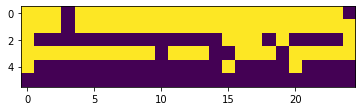

In [53]:
TF =pv>0.05 #True이면 통계적 유의성 부족. (설명력 x)
plt.imshow(TF.values)

In [54]:
pd.concat(se, axis=1)

0         1         2         3         4         5   \
Intercept  0.353703  0.198071  0.174154  0.190567  0.215432  0.190459   
market     1.925022  1.077998  0.947831  1.037158  1.172483  1.036569   
factor0    0.303707  0.170074  0.149538  0.163631  0.184981  0.163538   
factor1    0.290879  0.162890  0.143221  0.156719  0.177167  0.156630   
factor2    0.432958  0.242453  0.213177  0.233268  0.263704  0.233135   
factor3    0.475456  0.266252  0.234102  0.256165  0.289589  0.256020   

                 6         7         8         9         10        11  \
Intercept  0.147418  0.149197  0.146569  0.134136  0.179684  0.152698   
market     0.802319  0.812001  0.797699  0.730032  0.977928  0.831055   
factor0    0.126580  0.128108  0.125852  0.115176  0.154286  0.131114   
factor1    0.121234  0.122697  0.120536  0.110311  0.147769  0.125576   
factor2    0.180450  0.182628  0.179411  0.164192  0.219946  0.186913   
factor3    0.198163  0.200554  0.197022  0.180309  0.241536  0.205260   

                 12        13        14        15        16        17  \
Intercept  0.149624  0.152356  0.144205  0.172497  0.160157  0.155562   
market     0.814327  0.829197  0.784835  0.938811  0.871654  0.846644   
factor0    0.128475  0.130821  0.123822  0.148115  0.137519  0.133574   
factor1    0.123048  0.125295  0.118592  0.141858  0.131711  0.127932   
factor2    0.183151  0.186495  0.176518  0.211149  0.196044  0.190419   
factor3    0.201129  0.204801  0.193844  0.231875  0.215288  0.209110   

                 18        19        20        21        22        23  \
Intercept  0.137677  0.154839  0.195076  0.189302  0.181521  0.205967   
market     0.749306  0.842707  1.061699  1.030273  0.987925  1.120970   
factor0    0.118217  0.132952  0.167502  0.162544  0.155863  0.176853   
factor1    0.113223  0.127337  0.160427  0.155679  0.149280  0.169383   
factor2    0.168527  0.189534  0.238787  0.231719  0.222195  0.252118   
factor3    0.185069  0.208138  0.262226  0.254465  0.244005  0.276866   

                 24  
Intercept  0.189911  
market     1.033585  
factor0    0.163067  
factor1    0.156179  
factor2    0.232464  
factor3    0.255283

In [55]:
r

[0.16956087380279805,
 0.39913494072164624,
 0.5700031042185343,
 0.46183614427059727,
 0.4232252672281698,
 0.5530409798972926,
 0.6812766154505252,
 0.6720305745950439,
 0.6466268290570107,
 0.6508239861781748,
 0.6218457314984105,
 0.6261124747313835,
 0.6074989904124244,
 0.6107010953906395,
 0.553071294887612,
 0.5754883224089857,
 0.48415061487992417,
 0.4631549207708586,
 0.5529360944699305,
 0.4494991540185027,
 0.3648141984854729,
 0.3258276686172268,
 0.3691974071961913,
 0.2596541298112902,
 0.39642013230790396]

### 2. (size/OP) 25포트폴리오에 대해 OLS분석

In [56]:
# OP pfo
rmw_pfo_mask = make_portfolio(get_mask(Market_cap[0], Market_cap[1], breakpoint = [0.2, 0.4, 0.6, 0.8], market_bp='KOSPI'), RMW_base_shifted, breakpoint = [0.2, 0.4, 0.6, 0.8])

pfo25 = serialize_pfo([get_mask(Market_cap[0], Market_cap[1], breakpoint = [0.2, 0.4, 0.6, 0.8], market_bp='KOSPI'), rmw_pfo_mask])

pfo_return = get_factor_on_date_by_mask(pfo25, term = 'm', winsorize_limits= 0.01, weight = 'VW')

  0%|          | 0/120 [00:00<?, ?it/s]

#### 2. (size/OP) 25포트폴리오에 대해 OLS분석     
    (1) Rm, SMB, HML, RMW(OP), CMA(Inv)로 regression       


In [57]:
coef = []
tvalues = []
pvalues = []
se = []
r = []
R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, factors['SMB'], factors['HML'], factors['RMW'], factors['CMA'])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    pvalues.append(model.pvalues)
    se.append(model.bse)
    r.append(model.rsquared_adj)

  0%|          | 0/120 [00:00<?, ?it/s]

In [58]:
pd.concat(coef, axis=1)

0         1         2         3         4         5   \
Intercept -0.402604 -0.015966 -0.043428 -0.396554 -0.161800 -0.279892   
market     0.074744 -0.001205  0.369124 -2.822076 -0.280912 -1.089606   
factor0    0.583414  0.815704  0.909557  0.801532  0.886632  0.830677   
factor1   -0.030690 -0.148044  0.091457 -0.016509 -0.078347 -0.212842   
factor2    0.647507  0.688751  0.936442  0.644969  0.741664  0.753978   
factor3    1.314566  0.915683  1.274084  0.959927  1.091794  1.424425   

                 6         7         8         9         10        11  \
Intercept -0.267641 -0.027941 -0.277971 -0.261922 -0.224969 -0.245124   
market    -0.901092  0.336964 -0.591925 -0.724230 -1.178334 -0.886115   
factor0    0.855736  0.860397  0.724435  0.723462  0.675800  0.543867   
factor1   -0.212627  0.050869 -0.117324  0.000701 -0.304314 -0.167388   
factor2    0.916539  0.977538  0.826199  0.876215  0.558246  1.002040   
factor3    1.477962  1.492194  1.449322  1.291171  1.708106  1.710386   

                 12        13        14        15        16        17  \
Intercept -0.168389 -0.063994 -0.198775 -0.088169 -0.152749 -0.162816   
market    -0.345045  0.244751 -0.398386 -0.652004 -0.332425 -0.622800   
factor0    0.652533  0.675245  0.592820 -0.129151  0.157247  0.150841   
factor1   -0.144093 -0.044602 -0.254548 -0.572563 -0.135301 -0.053948   
factor2    0.899258  0.972892  0.753216  0.480217  0.938101  0.884155   
factor3    1.446257  1.498934  1.193824  2.167091  1.700319  1.567637   

                 18        19        20        21        22        23  \
Intercept -0.188203 -0.153469 -0.221741 -0.219430 -0.124266 -0.254634   
market    -0.313145 -0.374299 -0.414955 -0.340899  0.055102 -0.144927   
factor0    0.432744  0.185779 -0.606404 -0.594547 -0.438202 -0.483037   
factor1   -0.150844 -0.345611 -0.132779 -0.202844 -0.006681 -0.178981   
factor2    0.886936  0.903917  0.248566  1.022875  1.401625  1.259168   
factor3    1.360932  1.485846  1.895943  1.976022  1.981783  1.824817   

                 24  
Intercept -0.379892  
market    -1.014523  
factor0   -0.161585  
factor1   -0.324009  
factor2    1.789056  
factor3    1.865048

In [59]:
pd.concat(tvalues, axis=1)

0         1         2         3         4         5   \
Intercept -1.137108 -0.080474 -0.248966 -2.078804 -0.750328 -1.468225   
market     0.038734 -0.001114  0.388268 -2.714388 -0.239021 -1.048732   
factor0    1.899084  4.738479  6.009529  4.842561  4.738717  5.022020   
factor1   -0.105633 -0.909350  0.638945 -0.105465 -0.442764 -1.360627   
factor2    1.488639  2.825836  4.369878  2.752144  2.799638  3.219459   
factor3    2.701925  3.358735  5.315355  3.661982  3.684528  5.437630   

                 6         7         8         9         10        11  \
Intercept -1.813699 -0.187062 -1.895909 -1.950580 -1.250612 -1.603956   
market    -1.120402  0.413922 -0.740760 -0.989601 -1.201878 -1.063868   
factor0    6.683373  6.638734  5.694569  6.209407  4.329738  4.101488   
factor1   -1.755937  0.415029 -0.975181  0.006360 -2.061581 -1.334773   
factor2    5.055738  5.327189  4.586952  5.311574  2.526077  5.337181   
factor3    7.288583  7.270019  7.193670  6.997489  6.910064  8.144549   

                 12        13        14        15        16        17  \
Intercept -1.125347 -0.419635 -1.377261 -0.509792 -0.952743 -1.045579   
market    -0.423098  0.294475 -0.506466 -0.691702 -0.380438 -0.733837   
factor0    5.025956  5.103135  4.733915 -0.860636  1.130381  1.116409   
factor1   -1.173532 -0.356421 -2.149327 -4.034397 -1.028440 -0.422196   
factor2    4.891909  5.192994  4.248102  2.260142  4.762874  4.621774   
factor3    7.033731  7.152896  6.019515  9.118449  7.717839  7.326088   

                 18        19        20        21        22        23  \
Intercept -1.365300 -0.988565 -1.136126 -1.158030 -0.683876 -1.235512   
market    -0.416812 -0.442381 -0.390099 -0.330097  0.055640 -0.129024   
factor0    3.618066  1.379194 -3.580852 -3.616213 -2.779346 -2.701184   
factor1   -1.333551 -2.713011 -0.829065 -1.304561 -0.044808 -1.058316   
factor2    5.237398  4.739530  1.036676  4.394085  6.278827  4.973199   
factor3    7.184655  6.965090  7.069248  7.588984  7.936858  6.443433   

                 24  
Intercept -2.001959  
market    -0.980954  
factor0   -0.981387  
factor1   -2.080804  
factor2    7.674318  
factor3    7.152401

In [60]:
pv = pd.concat(pvalues, axis=1)
pv

0         1             2         3         4             5   \
Intercept  0.257877  0.936001  8.038348e-01  0.039879  0.454603  1.447970e-01   
market     0.969170  0.999113  6.985418e-01  0.007672  0.811518  2.965200e-01   
factor0    0.060081  0.000006  2.281834e-08  0.000004  0.000006  1.907318e-06   
factor1    0.916059  0.365084  5.241405e-01  0.916192  0.658775  1.763155e-01   
factor2    0.139344  0.005570  2.756115e-05  0.006890  0.006010  1.673239e-03   
factor3    0.007947  0.001065  5.353213e-07  0.000381  0.000352  3.115760e-07   

                     6             7             8             9   \
Intercept  7.235462e-02  8.519443e-01  6.050379e-02  5.356150e-02   
market     2.648974e-01  6.797088e-01  4.603622e-01  3.244650e-01   
factor0    9.004560e-10  1.120459e-09  9.785129e-08  8.886633e-09   
factor1    8.178481e-02  6.789006e-01  3.315351e-01  9.949367e-01   
factor2    1.651550e-06  5.081504e-07  1.161648e-05  5.442998e-07   
factor3    4.407152e-11  4.841072e-11  7.117168e-11  1.903432e-10   

                     10            11            12            13  \
Intercept  2.136368e-01  1.114908e-01  2.628058e-01  6.755416e-01   
market     2.319014e-01  2.896369e-01  6.730207e-01  7.689304e-01   
factor0    3.224270e-05  7.730176e-05  1.875583e-06  1.347690e-06   
factor1    4.152154e-02  1.846103e-01  2.430285e-01  7.221838e-01   
factor2    1.290690e-02  4.862606e-07  3.307186e-06  9.139280e-07   
factor3    2.941406e-10  5.378839e-13  1.588281e-10  8.738584e-11   

                     14            15            16            17  \
Intercept  1.711296e-01  6.111825e-01  3.427362e-01  2.979672e-01   
market     6.135074e-01  4.905309e-01  7.043282e-01  4.645545e-01   
factor0    6.379044e-06  3.912452e-01  2.606883e-01  2.665948e-01   
factor1    3.372267e-02  9.937454e-05  3.059200e-01  6.736775e-01   
factor2    4.423528e-05  2.571158e-02  5.660832e-06  1.008892e-05   
factor3    2.177571e-08  3.130857e-15  4.921563e-12  3.644683e-11   

                     18            19            20            21  \
Intercept  1.748470e-01  3.249697e-01  2.582867e-01  2.492722e-01   
market     6.776000e-01  6.590520e-01  6.971916e-01  7.419323e-01   
factor0    4.438102e-04  1.705348e-01  5.046078e-04  4.466653e-04   
factor1    1.850093e-01  7.701849e-03  4.088003e-01  1.946698e-01   
factor2    7.532802e-07  6.233212e-06  3.020808e-01  2.506204e-05   
factor3    7.447798e-11  2.237108e-10  1.329682e-10  9.541677e-12   

                     22            23            24  
Intercept  4.954414e-01  2.191802e-01  4.766353e-02  
market     9.557262e-01  8.975657e-01  3.286926e-01  
factor0    6.372726e-03  7.963723e-03  3.284803e-01  
factor1    9.643388e-01  2.921486e-01  3.969190e-02  
factor2    6.383855e-09  2.347151e-06  6.157014e-12  
factor3    1.586032e-12  2.895157e-09  8.760340e-11

In [61]:
pv>0.1 #True이면 통계적 유의성 부족. (설명력 x)

0      1      2      3      4      5      6      7      8   \
Intercept   True   True   True  False   True   True  False   True  False   
market      True   True   True  False   True   True   True   True   True   
factor0    False  False  False  False  False  False  False  False  False   
factor1     True   True   True   True   True   True  False   True   True   
factor2     True  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              9      10     11     12     13     14     15     16     17  \
Intercept  False   True   True   True   True   True   True   True   True   
market      True   True   True   True   True   True   True   True   True   
factor0    False  False  False  False  False  False   True   True   True   
factor1     True  False   True   True   True  False  False   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              18     19     20     21     22     23     24  
Intercept   True   True   True   True   True   True  False  
market      True   True   True   True   True   True   True  
factor0    False   True  False  False  False  False   True  
factor1     True  False   True   True   True   True  False  
factor2    False  False   True  False  False  False  False  
factor3    False  False  False  False  False  False  False

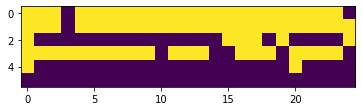

In [62]:
TF =pv>0.05 #True이면 통계적 유의성 부족. (설명력 x)
plt.imshow(TF.values)

In [63]:
pd.concat(se, axis=1)

0         1         2         3         4         5   \
Intercept  0.354059  0.198398  0.174435  0.190761  0.215638  0.190633   
market     1.929674  1.081296  0.950694  1.039673  1.175260  1.038975   
factor0    0.307208  0.172145  0.151353  0.165518  0.187104  0.165407   
factor1    0.290534  0.162801  0.143138  0.156535  0.176949  0.156429   
factor2    0.434966  0.243734  0.214295  0.234352  0.264914  0.234194   
factor3    0.486529  0.272627  0.239699  0.262133  0.296319  0.261957   

                 6         7         8         9         10        11  \
Intercept  0.147566  0.149368  0.146616  0.134279  0.179887  0.152825   
market     0.804258  0.814076  0.799079  0.731841  0.980410  0.832918   
factor0    0.128040  0.129603  0.127215  0.116511  0.156083  0.132602   
factor1    0.121090  0.122568  0.120310  0.110187  0.147612  0.125405   
factor2    0.181287  0.183500  0.180119  0.164963  0.220993  0.187747   
factor3    0.202778  0.205253  0.201472  0.184519  0.247191  0.210004   

                 12        13        14        15        16        17  \
Intercept  0.149633  0.152499  0.144326  0.172951  0.160325  0.155719   
market     0.815520  0.831143  0.786600  0.942608  0.873795  0.848689   
factor0    0.129833  0.132320  0.125228  0.150065  0.139110  0.135113   
factor1    0.122786  0.125138  0.118432  0.141920  0.131560  0.127780   
factor2    0.183826  0.187347  0.177307  0.212472  0.196961  0.191302   
factor3    0.205617  0.209556  0.198326  0.237660  0.220310  0.213980   

                 18        19        20        21        22        23  \
Intercept  0.137847  0.155244  0.195173  0.189485  0.181708  0.206096   
market     0.751286  0.846101  1.063719  1.032721  0.990336  1.123252   
factor0    0.119606  0.134701  0.169346  0.164411  0.157664  0.178824   
factor1    0.113115  0.127390  0.160155  0.155488  0.149106  0.169118   
factor2    0.169347  0.190719  0.239772  0.232785  0.223230  0.253191   
factor3    0.189422  0.213328  0.268196  0.260380  0.249694  0.283206   

                 24  
Intercept  0.189760  
market     1.034220  
factor0    0.164650  
factor1    0.155714  
factor2    0.233122  
factor3    0.260758

In [64]:
r

[0.16959304343448833,
 0.3983874436525052,
 0.5695014014135917,
 0.46184798346558653,
 0.4233030627586172,
 0.5531439540679652,
 0.6812892726800024,
 0.6719531282089113,
 0.6471249943885302,
 0.650795161739693,
 0.6217689697145712,
 0.626257666371828,
 0.6082587678959583,
 0.6107709036514455,
 0.5532385809676402,
 0.5741253757516442,
 0.4841299124493028,
 0.4631772832783192,
 0.5527513191585145,
 0.44775051871206606,
 0.3654896830267387,
 0.3259083835878318,
 0.3691920956493243,
 0.26024653975719836,
 0.3986122823732642]

#### 2. (size/OP) 25포트폴리오에 대해 OLS분석     
    (2) HML를 다른 4개 팩터에 projection시켜서 HMLO로 대체      
     

In [65]:
coef = []
tvalues = []
pvalues = []
se = []
r = []
R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, factors['SMB'], factors['HMLO'], factors['RMW'], factors['CMA'])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    pvalues.append(model.pvalues)
    se.append(model.bse)
    r.append(model.rsquared_adj)

  0%|          | 0/120 [00:00<?, ?it/s]

In [66]:
pd.concat(coef, axis=1)

0         1         2         3         4         5   \
Intercept -0.404426 -0.024981 -0.037827 -0.397543 -0.166522 -0.292757   
market     0.062844 -0.053444  0.400674 -2.828284 -0.309655 -1.166888   
factor0    0.588273  0.839080  0.895124  0.804143  0.899016  0.864311   
factor1   -0.023884 -0.160409  0.105415 -0.014546 -0.075299 -0.211573   
factor2    0.643207  0.668239  0.949082  0.642665  0.730759  0.724390   
factor3    1.303793  0.863978  1.305990  0.954142  1.064376  1.349979   

                 6         7         8         9         10        11  \
Intercept -0.280501 -0.024845 -0.285015 -0.261829 -0.243379 -0.255238   
market    -0.978140  0.354955 -0.635618 -0.725122 -1.288486 -0.946995   
factor0    0.889334  0.852364  0.742987  0.723364  0.723884  0.570319   
factor1   -0.212719  0.054763 -0.107062  0.010724 -0.305497 -0.165487   
factor2    0.886988  0.984589  0.809841  0.876261  0.515957  0.978766   
factor3    1.403600  1.509963  1.408231  1.291359  1.601683  1.651834   

                 12        13        14        15        16        17  \
Intercept -0.177043 -0.066673 -0.214165 -0.122832 -0.160934 -0.166076   
market    -0.398629  0.228164 -0.490739 -0.858702 -0.381409 -0.642427   
factor0    0.675317  0.682298  0.633043 -0.038688  0.178626  0.159367   
factor1   -0.132175 -0.040903 -0.253665 -0.579620 -0.135752 -0.053287   
factor2    0.879170  0.966674  0.717834  0.400676  0.919299  0.876653   
factor3    1.395795  1.483314  1.104794  1.966885  1.653002  1.548766   

                 18        19        20        21        22        23  \
Intercept -0.197336 -0.174414 -0.229710 -0.231694 -0.124677 -0.265422   
market    -0.367566 -0.498549 -0.464465 -0.414478  0.052847 -0.210621   
factor0    0.456576  0.240378 -0.585408 -0.562494 -0.437148 -0.454746   
factor1   -0.153007 -0.354397 -0.120629 -0.202264 -0.008132 -0.171731   
factor2    0.865982  0.855927  0.230050  0.994680  1.400704  1.234256   
factor3    1.308189  1.365023  1.849436  1.905077  1.979454  1.762180   

                 24  
Intercept -0.399409  
market    -1.133730  
factor0   -0.110367  
factor1   -0.308428  
factor2    1.743944  
factor3    1.751641

In [67]:
pd.concat(tvalues, axis=1)

0         1         2         3         4         5   \
Intercept -1.143405 -0.126124 -0.217204 -2.086104 -0.772972 -1.537116   
market     0.032646 -0.049577  0.422727 -2.726956 -0.264102 -1.125721   
factor0    1.936972  4.933625  5.985948  4.914382  4.860058  5.285087   
factor1   -0.082109 -0.984767  0.736028 -0.092815 -0.425015 -1.350783   
factor2    1.485611  2.756158  4.452084  2.755052  2.771137  3.107167   
factor3    2.742194  3.244962  5.578716  3.724715  3.675477  5.272952   

                 6         7         8         9         10        11  \
Intercept -1.902759 -0.166525 -1.944577 -1.951972 -1.354482 -1.671525   
market    -1.219141  0.437136 -0.796815 -0.993274 -1.317567 -1.139510   
factor0    7.025837  6.653480  5.903676  6.280519  4.691833  4.349790   
factor1   -1.754613  0.446329 -0.888216  0.097217 -2.067395 -1.317823   
factor2    4.915420  5.391236  4.513887  5.336814  2.345832  5.236480   
factor3    7.083063  7.528952  7.147595  7.161931  6.631239  8.047512   

                 12        13        14        15        16        17  \
Intercept -1.183252 -0.437611 -1.485141 -0.712081 -1.004846 -1.067584   
market    -0.489520  0.275162 -0.625277 -0.914670 -0.437569 -0.758792   
factor0    5.256411  5.215508  5.112528 -0.261205  1.298917  1.193102   
factor1   -1.074168 -0.326452 -2.138974 -4.085906 -1.030683 -0.416525   
factor2    4.800257  5.183372  4.066640  1.897604  4.689243  4.603809   
factor3    6.939813  7.242697  5.699385  8.482534  7.678106  7.406449   

                 18        19        20        21        22        23  \
Intercept -1.433325 -1.126426 -1.177538 -1.223939 -0.686848 -1.288662   
market    -0.490542 -0.591604 -0.437474 -0.402299  0.053493 -0.187891   
factor0    3.862201  1.808003 -3.494923 -3.460558 -2.804690 -2.571314   
factor1   -1.351374 -2.783150 -0.751921 -1.299241 -0.054476 -1.013862   
factor2    5.138543  4.515963  0.963409  4.292609  6.303950  4.895549   
factor3    7.068648  6.558257  7.052824  7.486609  8.112349  6.364747   

                 24  
Intercept -2.103142  
market    -1.096890  
factor0   -0.676822  
factor1   -1.974837  
factor2    7.501989  
factor3    6.861573

In [68]:
pv = pd.concat(pvalues, axis=1)
pv

0         1             2         3         4             5   \
Intercept  0.255266  0.899856  8.284377e-01  0.039200  0.441139  1.270360e-01   
market     0.974014  0.960546  6.732904e-01  0.007403  0.792178  2.626479e-01   
factor0    0.055223  0.000003  2.547943e-08  0.000003  0.000004  6.114402e-07   
factor1    0.934704  0.326824  4.632254e-01  0.926213  0.671627  1.794399e-01   
factor2    0.140142  0.006812  1.993112e-05  0.006833  0.006525  2.384590e-03   
factor3    0.007089  0.001542  1.655204e-07  0.000306  0.000363  6.448399e-07   

                     6             7             8             9   \
Intercept  5.959461e-02  8.680388e-01  5.428925e-02  5.339385e-02   
market     2.253071e-01  6.628399e-01  4.272149e-01  3.226799e-01   
factor0    1.652194e-10  1.042469e-09  3.737883e-08  6.332445e-09   
factor1    8.201236e-02  6.562062e-01  3.762950e-01  9.227248e-01   
factor2    2.995955e-06  3.829000e-07  1.558217e-05  4.870489e-07   
factor3    1.240770e-10  1.297446e-11  8.974637e-11  8.350329e-11   

                     10            11            12            13  \
Intercept  1.782612e-01  9.736095e-02  2.391708e-01  6.624962e-01   
market     1.902903e-01  2.568791e-01  6.254145e-01  7.836897e-01   
factor0    7.582326e-06  2.981567e-05  6.932473e-07  8.286949e-07   
factor1    4.096071e-02  1.902050e-01  2.850156e-01  7.446806e-01   
factor2    2.071267e-02  7.563036e-07  4.848802e-06  9.529122e-07   
factor3    1.162280e-09  8.922341e-13  2.537076e-10  5.557791e-11   

                     14            15            16            17  \
Intercept  1.402665e-01  4.778695e-01  3.170990e-01  2.879638e-01   
market     5.330389e-01  3.622956e-01  6.625267e-01  4.495429e-01   
factor0    1.294301e-06  7.944058e-01  1.965935e-01  2.353067e-01   
factor1    3.457145e-02  8.196526e-05  3.048714e-01  6.778092e-01   
factor2    8.810416e-05  6.027774e-02  7.663173e-06  1.085099e-05   
factor3    9.572475e-08  9.130825e-14  6.038254e-12  2.423422e-11   

                     18            19            20            21  \
Intercept  1.545018e-01  2.623507e-01  2.414332e-01  2.234990e-01   
market     6.246933e-01  5.552873e-01  6.625955e-01  6.882170e-01   
factor0    1.869860e-04  7.324249e-02  6.763793e-04  7.594159e-04   
factor1    1.792513e-01  6.303253e-03  4.536484e-01  1.964827e-01   
factor2    1.156970e-06  1.545330e-05  3.373817e-01  3.724771e-05   
factor3    1.333686e-10  1.659186e-09  1.443629e-10  1.610770e-11   

                     22            23            24  
Intercept  4.935735e-01  2.001246e-01  3.765318e-02  
market     9.574331e-01  8.512958e-01  2.750011e-01  
factor0    5.922744e-03  1.141822e-02  4.998898e-01  
factor1    9.566510e-01  3.127955e-01  5.070415e-02  
factor2    5.661340e-09  3.257026e-06  1.489120e-11  
factor3    6.363424e-13  4.229716e-09  3.741219e-10

In [69]:
pv>0.1 #True이면 통계적 유의성 부족. (설명력 x)

0      1      2      3      4      5      6      7      8   \
Intercept   True   True   True  False   True   True  False   True  False   
market      True   True   True  False   True   True   True   True   True   
factor0    False  False  False  False  False  False  False  False  False   
factor1     True   True   True   True   True   True  False   True   True   
factor2     True  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              9      10     11     12     13     14     15     16     17  \
Intercept  False   True  False   True   True   True   True   True   True   
market      True   True   True   True   True   True   True   True   True   
factor0    False  False  False  False  False  False   True   True   True   
factor1     True  False   True   True   True  False  False   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              18     19     20     21     22     23     24  
Intercept   True   True   True   True   True   True  False  
market      True   True   True   True   True   True   True  
factor0    False  False  False  False  False  False   True  
factor1     True  False   True   True   True   True  False  
factor2    False  False   True  False  False  False  False  
factor3    False  False  False  False  False  False  False

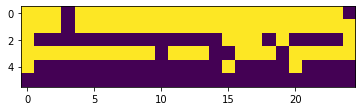

In [70]:
TF =pv>0.05 #True이면 통계적 유의성 부족. (설명력 x)
plt.imshow(TF.values)

In [71]:
pd.concat(se, axis=1)

0         1         2         3         4         5   \
Intercept  0.353703  0.198071  0.174154  0.190567  0.215432  0.190459   
market     1.925022  1.077998  0.947831  1.037158  1.172483  1.036569   
factor0    0.303707  0.170074  0.149538  0.163631  0.184981  0.163538   
factor1    0.290879  0.162890  0.143221  0.156719  0.177167  0.156630   
factor2    0.432958  0.242453  0.213177  0.233268  0.263704  0.233135   
factor3    0.475456  0.266252  0.234102  0.256165  0.289589  0.256020   

                 6         7         8         9         10        11  \
Intercept  0.147418  0.149197  0.146569  0.134136  0.179684  0.152698   
market     0.802319  0.812001  0.797699  0.730032  0.977928  0.831055   
factor0    0.126580  0.128108  0.125852  0.115176  0.154286  0.131114   
factor1    0.121234  0.122697  0.120536  0.110311  0.147769  0.125576   
factor2    0.180450  0.182628  0.179411  0.164192  0.219946  0.186913   
factor3    0.198163  0.200554  0.197022  0.180309  0.241536  0.205260   

                 12        13        14        15        16        17  \
Intercept  0.149624  0.152356  0.144205  0.172497  0.160157  0.155562   
market     0.814327  0.829197  0.784835  0.938811  0.871654  0.846644   
factor0    0.128475  0.130821  0.123822  0.148115  0.137519  0.133574   
factor1    0.123048  0.125295  0.118592  0.141858  0.131711  0.127932   
factor2    0.183151  0.186495  0.176518  0.211149  0.196044  0.190419   
factor3    0.201129  0.204801  0.193844  0.231875  0.215288  0.209110   

                 18        19        20        21        22        23  \
Intercept  0.137677  0.154839  0.195076  0.189302  0.181521  0.205967   
market     0.749306  0.842707  1.061699  1.030273  0.987925  1.120970   
factor0    0.118217  0.132952  0.167502  0.162544  0.155863  0.176853   
factor1    0.113223  0.127337  0.160427  0.155679  0.149280  0.169383   
factor2    0.168527  0.189534  0.238787  0.231719  0.222195  0.252118   
factor3    0.185069  0.208138  0.262226  0.254465  0.244005  0.276866   

                 24  
Intercept  0.189911  
market     1.033585  
factor0    0.163067  
factor1    0.156179  
factor2    0.232464  
factor3    0.255283

In [72]:
r

[0.16956087380279805,
 0.39913494072164624,
 0.5700031042185343,
 0.46183614427059727,
 0.4232252672281698,
 0.5530409798972926,
 0.6812766154505252,
 0.6720305745950439,
 0.6466268290570107,
 0.6508239861781748,
 0.6218457314984105,
 0.6261124747313835,
 0.6074989904124244,
 0.6107010953906395,
 0.553071294887612,
 0.5754883224089857,
 0.48415061487992417,
 0.4631549207708586,
 0.5529360944699305,
 0.4494991540185027,
 0.3648141984854729,
 0.3258276686172268,
 0.3691974071961913,
 0.2596541298112902,
 0.39642013230790396]

### 3. (size/INV)로 25포트폴리오에 대해 OLS분석

In [73]:
# INV pfo
cma_pfo_mask = make_portfolio(get_mask(Market_cap[0], Market_cap[1], breakpoint = [0.2, 0.4, 0.6, 0.8], market_bp='KOSPI'), CMA_base_shifted, breakpoint = [0.2, 0.4, 0.6, 0.8])

pfo25 = serialize_pfo([get_mask(Market_cap[0], Market_cap[1], breakpoint = [0.2, 0.4, 0.6, 0.8], market_bp='KOSPI'), cma_pfo_mask])

pfo_return = get_factor_on_date_by_mask(pfo25, term = 'm', winsorize_limits= 0.01, weight = 'VW')

  0%|          | 0/120 [00:00<?, ?it/s]

#### 3. (size/INV)로 25포트폴리오에 대해 OLS분석      
    (1) Rm, SMB, HML, RMW, CMA로 regression       

In [74]:
coef = []
tvalues = []
pvalues = []
se = []
r = []
R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, factors['SMB'], factors['HML'], factors['RMW'], factors['CMA'])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    pvalues.append(model.pvalues)
    se.append(model.bse)
    r.append(model.rsquared_adj)

  0%|          | 0/120 [00:00<?, ?it/s]

In [75]:
pd.concat(coef, axis=1)

0         1         2         3         4         5   \
Intercept -0.356757 -0.129141 -0.268146 -0.071142 -0.189477 -0.575710   
market     0.321394 -0.787835 -1.106975 -0.677489 -0.752955 -2.658300   
factor0    0.520919  0.978194  0.826571  0.875002  0.887636  0.918897   
factor1   -0.006181 -0.121324 -0.121557  0.076939 -0.060044 -0.338093   
factor2    0.916858  0.450844  1.056224  0.824249  0.999932  0.866988   
factor3    1.405704  0.863817  1.278917  1.065743  1.011961  1.529219   

                 6         7         8         9         10        11  \
Intercept -0.001959 -0.039782 -0.211767 -0.270781 -0.276992 -0.036992   
market     0.383459  0.123915 -0.262694 -0.473753 -1.187702 -0.283746   
factor0    0.789805  0.848444  0.683905  0.774714  0.640446  0.569531   
factor1   -0.136419  0.091975 -0.110792 -0.044281 -0.538578 -0.050513   
factor2    1.079843  0.840010  0.804151  0.945075  0.712480  1.019210   
factor3    1.696851  1.354412  1.323850  1.402901  1.854059  1.757947   

                 12        13        14        15        16        17  \
Intercept -0.198831 -0.159135 -0.189786 -0.087574 -0.213777 -0.119293   
market    -0.354254 -0.446042 -0.274233 -0.073597 -1.160302 -0.166495   
factor0    0.702879  0.645035  0.673957  0.020901  0.085489  0.222702   
factor1   -0.036103 -0.100246 -0.209268 -0.527382 -0.180081 -0.052653   
factor2    0.991679  0.855892  0.720751  0.670098  0.915474  1.113081   
factor3    1.427881  1.326510  1.217274  2.007362  1.776800  1.618241   

                 18        19        20        21        22        23  \
Intercept -0.244991 -0.151447 -0.099673 -0.197213 -0.168065 -0.365583   
market    -0.386407 -0.617613  0.189230 -0.093462  0.094250 -1.678721   
factor0    0.294894  0.358047 -0.559182 -0.560853 -0.578658 -0.171925   
factor1   -0.151313 -0.314862 -0.077662  0.061018 -0.060962 -0.153099   
factor2    0.626733  0.904889  0.700291  1.072058  1.106720  0.964068   
factor3    1.287082  1.404065  2.282587  1.899197  1.794145  1.287195   

                 24  
Intercept -0.364273  
market    -0.528387  
factor0   -0.222088  
factor1   -0.410942  
factor2    1.261267  
factor3    1.344115

In [76]:
pd.concat(tvalues, axis=1)

0         1         2         3         4         5   \
Intercept -1.008659 -0.613130 -1.571410 -0.368242 -0.961010 -3.478018   
market     0.166726 -0.686301 -1.190278 -0.643433 -0.700699 -2.946620   
factor0    1.697406  5.352486  5.582667  5.219888  5.188583  6.397908   
factor1   -0.021295 -0.701963 -0.868117  0.485329 -0.371127 -2.489102   
factor2    2.110062  1.742349  5.038435  3.472871  4.128215  4.263461   
factor3    2.892231  2.984533  5.454160  4.014473  3.735093  6.723029   

                 6         7         8         9         10        11  \
Intercept -0.011929 -0.257668 -1.478834 -1.897062 -1.721693 -0.245436   
market     0.428490  0.147263 -0.336591 -0.608986 -1.354528 -0.345424   
factor0    5.543610  6.333494  5.504267  6.255294  4.587904  4.355028   
factor1   -1.012468  0.725980 -0.942864 -0.378056 -4.079577 -0.408422   
factor2    5.353170  4.428767  4.571084  5.389528  3.604808  5.504462   
factor3    7.520385  6.384033  6.727696  7.152490  8.386464  8.487951   

                 12        13        14        15        16        17  \
Intercept -1.189223 -1.170691 -1.261774 -0.555992 -1.484289 -0.844385   
market    -0.388765 -0.602068 -0.334525 -0.085733 -1.478154 -0.216231   
factor0    4.845114  5.468952  5.164078  0.152930  0.684082  1.816736   
factor1   -0.263149 -0.898718 -1.695501 -4.080337 -1.523715 -0.454174   
factor2    4.828054  5.125279  3.900528  3.462994  5.173968  6.413171   
factor3    6.214970  7.101581  5.889421  9.274380  8.977643  8.335569   

                 18        19         20        21        22        23  \
Intercept -1.636784 -0.957423  -0.611083 -0.936868 -0.905530 -1.697304   
market    -0.473673 -0.716392   0.212866 -0.081465  0.093175 -1.430029   
factor0    2.270656  2.608708  -3.951109 -3.070681 -3.593279 -0.919931   
factor1   -1.231959 -2.425727  -0.580243  0.353250 -0.400278 -0.866212   
factor2    3.408359  4.656491   3.494803  4.145545  4.853830  3.643366   
factor3    6.257706  6.459469  10.183973  6.565676  7.034778  4.348960   

                 24  
Intercept -1.813327  
market    -0.482607  
factor0   -1.274144  
factor1   -2.492925  
factor2    5.110671  
factor3    4.869150

In [77]:
pv = pd.concat(pvalues, axis=1)
pv

0             1             2             3             4   \
Intercept  0.315274  5.410117e-01  1.188589e-01  7.133760e-01  3.385811e-01   
market     0.867881  4.939170e-01  2.364099e-01  5.212351e-01  4.849186e-01   
factor0    0.092348  4.545077e-07  1.625942e-07  8.130388e-07  9.316037e-07   
factor1    0.983047  4.841330e-01  3.871540e-01  6.283744e-01  7.112320e-01   
factor2    0.037040  8.414420e-02  1.778327e-06  7.286175e-04  6.988897e-05   
factor3    0.004583  3.475645e-03  2.894473e-07  1.070145e-04  2.946560e-04   

                     5             6             7             8   \
Intercept  7.160961e-04  9.905030e-01  7.971276e-01  1.419425e-01   
market     3.896535e-03  6.691031e-01  8.831848e-01  7.370443e-01   
factor0    3.606056e-09  1.938877e-07  4.914292e-09  2.313514e-07   
factor1    1.425048e-02  3.134583e-01  4.693387e-01  3.477444e-01   
factor2    4.169234e-05  4.531381e-07  2.185872e-05  1.238463e-05   
factor3    7.411644e-10  1.355529e-11  3.855112e-09  7.243548e-10   

                     9             10            11            12  \
Intercept  6.034996e-02  8.783753e-02  8.065599e-01  2.368232e-01   
market     5.437454e-01  1.782466e-01  7.304122e-01  6.981754e-01   
factor0    7.142672e-09  1.157193e-05  2.921120e-05  4.022855e-06   
factor1    7.060921e-01  8.393533e-05  6.837299e-01  7.929105e-01   
factor2    3.858087e-07  4.646282e-04  2.311490e-07  4.319472e-06   
factor3    8.756424e-11  1.513956e-13  8.873837e-14  8.654701e-09   

                     13            14            15            16  \
Intercept  2.441643e-01  2.096055e-01  5.793062e-01  1.404922e-01   
market     5.483244e-01  7.385981e-01  9.318293e-01  1.421241e-01   
factor0    2.709531e-07  1.036028e-06  8.787239e-01  4.953116e-01   
factor1    3.706974e-01  9.270996e-02  8.369618e-05  1.303493e-01   
factor2    1.225114e-06  1.627008e-04  7.532255e-04  9.925753e-07   
factor3    1.130754e-10  3.993463e-08  1.361660e-15  6.629447e-15   

                     17            18            19            20  \
Intercept  4.002227e-01  1.044334e-01  3.403797e-01  5.423610e-01   
market     8.291939e-01  6.366391e-01  4.752143e-01  8.318118e-01   
factor0    7.188484e-02  2.504606e-02  1.030623e-02  1.352227e-04   
factor1    6.505669e-01  2.204995e-01  1.684625e-02  5.628959e-01   
factor2    3.350366e-09  9.040849e-04  8.760280e-06  6.766527e-04   
factor3    1.978072e-13  7.060986e-09  2.679256e-09  1.031975e-17   

                     21            22        23        24  
Intercept  3.508072e-01  3.670943e-01  0.092368  0.072412  
market     9.352150e-01  9.259285e-01  0.155444  0.630300  
factor0    2.670410e-03  4.834806e-04  0.359551  0.205204  
factor1    7.245535e-01  6.897009e-01  0.388193  0.014106  
factor2    6.545162e-05  3.879046e-06  0.000407  0.000001  
factor3    1.600341e-09  1.579990e-10  0.000030  0.000004

In [78]:
pv>0.1 #True이면 통계적 유의성 부족. (설명력 x)

0      1      2      3      4      5      6      7      8   \
Intercept   True   True   True   True   True  False   True   True   True   
market      True   True   True   True   True  False   True   True   True   
factor0    False  False  False  False  False  False  False  False  False   
factor1     True   True   True   True   True  False   True   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              9      10     11     12     13     14     15     16     17  \
Intercept  False  False   True   True   True   True   True   True   True   
market      True   True   True   True   True   True   True   True   True   
factor0    False  False  False  False  False  False   True   True  False   
factor1     True  False   True   True   True  False  False   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              18     19     20     21     22     23     24  
Intercept   True   True   True   True   True  False  False  
market      True   True   True   True   True   True   True  
factor0    False  False  False  False  False   True   True  
factor1     True  False   True   True   True   True  False  
factor2    False  False  False  False  False  False  False  
factor3    False  False  False  False  False  False  False

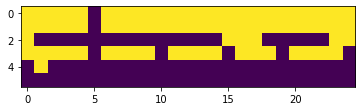

In [79]:
TF =pv>0.05 #True이면 통계적 유의성 부족. (설명력 x)
plt.imshow(TF.values)

In [80]:
pd.concat(se, axis=1)

0         1         2         3         4         5   \
Intercept  0.353694  0.210626  0.170640  0.193193  0.197165  0.165528   
market     1.927684  1.147944  0.930014  1.052928  1.074576  0.902152   
factor0    0.306891  0.182755  0.148060  0.167628  0.171075  0.143625   
factor1    0.290235  0.172836  0.140024  0.158530  0.161790  0.135829   
factor2    0.434517  0.258757  0.209633  0.237339  0.242219  0.203353   
factor3    0.486028  0.289431  0.234485  0.265475  0.270933  0.227460   

                 6         7         8         9         10        11  \
Intercept  0.164199  0.154391  0.143199  0.142737  0.160884  0.150720   
market     0.894908  0.841455  0.780454  0.777937  0.876839  0.821444   
factor0    0.142471  0.133961  0.124250  0.123849  0.139595  0.130776   
factor1    0.134739  0.126691  0.117506  0.117127  0.132018  0.123678   
factor2    0.201720  0.189671  0.175921  0.175354  0.197647  0.185161   
factor3    0.225633  0.212156  0.196776  0.196142  0.221078  0.207111   

                 12        13        14        15        16        17  \
Intercept  0.167194  0.135932  0.150412  0.157510  0.144027  0.141278   
market     0.911230  0.740850  0.819768  0.858452  0.784967  0.769986   
factor0    0.145070  0.117945  0.130509  0.136667  0.124968  0.122583   
factor1    0.137196  0.111543  0.123425  0.129250  0.118186  0.115930   
factor2    0.205399  0.166994  0.184783  0.193503  0.176938  0.173562   
factor3    0.229749  0.186791  0.206688  0.216442  0.197914  0.194137   

                 18        19        20        21        22        23  \
Intercept  0.149678  0.158182  0.163109  0.210503  0.185598  0.215390   
market     0.815767  0.862115  0.888966  1.147270  1.011538  1.173907   
factor0    0.129872  0.137251  0.141525  0.182648  0.161039  0.186889   
factor1    0.122823  0.129801  0.133844  0.172735  0.152299  0.176745   
factor2    0.183881  0.194328  0.200381  0.258605  0.228010  0.264609   
factor3    0.205680  0.217365  0.224135  0.289261  0.255039  0.295978   

                 24  
Intercept  0.200886  
market     1.094859  
factor0    0.174304  
factor1    0.164843  
factor2    0.246791  
factor3    0.276047

In [81]:
r

[0.15595200514385177,
 0.44318368697034083,
 0.5550696604177867,
 0.46894656443910365,
 0.43874959599134467,
 0.6734546274714251,
 0.6415329922243524,
 0.6363177098771592,
 0.6162883273729378,
 0.6553569129902697,
 0.6865094880891027,
 0.6458281999869329,
 0.5586432256288426,
 0.6269008065666506,
 0.569099812553704,
 0.5829417942712585,
 0.5550651717368837,
 0.5338846179927623,
 0.458285072414069,
 0.4742192066843375,
 0.519696215555463,
 0.2702298614108769,
 0.2902189659641028,
 0.1699629238289112,
 0.21753190594274407]

#### 3. (size/INV)로 25포트폴리오에 대해 OLS분석      
    (2) HML를 다른 4개 팩터에 projection시켜서 HMLO로 대체    

In [82]:
coef = []
tvalues = []
pvalues = []
se = []
r = []
R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, factors['SMB'], factors['HMLO'], factors['RMW'], factors['CMA'])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    pvalues.append(model.pvalues)
    se.append(model.bse)
    r.append(model.rsquared_adj)

  0%|          | 0/120 [00:00<?, ?it/s]

In [83]:
pd.concat(coef, axis=1)

0         1         2         3         4         5   \
Intercept -0.357054 -0.136494 -0.275530 -0.066458 -0.193106 -0.596141   
market     0.317421 -0.831468 -1.150281 -0.650294 -0.774774 -2.781202   
factor0    0.521916  0.997361  0.845770  0.862852  0.897125  0.972324   
factor1    0.008980 -0.124269 -0.128103  0.082968 -0.059534 -0.334833   
factor2    0.915922  0.433997  1.039363  0.834912  0.991584  0.819982   
factor3    1.403456  0.821403  1.236441  1.092617  0.990958  1.410957   

                 6         7         8         9         10        11  \
Intercept -0.010228 -0.034154 -0.218417 -0.273407 -0.309600 -0.040015   
market     0.334455  0.155762 -0.303997 -0.490977 -1.382067 -0.302766   
factor0    0.811356  0.833927  0.701425  0.781724  0.725539  0.577521   
factor1   -0.140235  0.104976 -0.100728 -0.033991 -0.545786 -0.044272   
factor2    1.060902  0.852727  0.788701  0.938869  0.637664  1.012158   
factor3    1.649162  1.386505  1.285044  1.387356  1.665740  1.740245   

                 12        13        14        15        16        17  \
Intercept -0.201000 -0.165184 -0.202409 -0.119492 -0.224676 -0.122467   
market    -0.367667 -0.482679 -0.350828 -0.264203 -1.225397 -0.185808   
factor0    0.708588  0.660879  0.707033  0.104228  0.113942  0.231024   
factor1   -0.033226 -0.097567 -0.202677 -0.531982 -0.181558 -0.050634   
factor2    0.986647  0.841945  0.691632  0.596824  0.890453  1.105753   
factor3    1.415238  1.291435  1.144048  1.822944  1.713828  1.599815   

                 18        19        20        21        22        23  \
Intercept -0.254168 -0.170538 -0.104295 -0.193539 -0.171720 -0.374848   
market    -0.440655 -0.730611  0.159387 -0.070979  0.071437 -1.734059   
factor0    0.318797  0.407787 -0.546891 -0.570499 -0.569017 -0.147735   
factor1   -0.156468 -0.324592 -0.062813  0.057790 -0.054668 -0.154388   
factor2    0.605729  0.861178  0.689422  1.080555  1.098215  0.942796   
factor3    1.234192  1.294002  2.255341  1.920556  1.772789  1.233658   

                 24  
Intercept -0.389104  
market    -0.677801  
factor0   -0.157149  
factor1   -0.406720  
factor2    1.204132  
factor3    1.200369

In [84]:
pd.concat(tvalues, axis=1)

0         1         2         3         4         5   \
Intercept -1.010539 -0.648768 -1.616922 -0.344410 -0.980410 -3.603043   
market     0.165066 -0.726149 -1.240299 -0.619213 -0.722752 -3.088561   
factor0    1.720294  5.520938  5.780363  5.207708  5.304539  6.844080   
factor1    0.030904 -0.718233 -0.914120  0.522832 -0.367536 -2.460794   
factor2    2.117729  1.685223  4.982873  3.534765  4.112769  4.048725   
factor3    2.954920  2.904431  5.397850  4.212334  3.742784  6.343991   

                 6         7         8         9         10        11  \
Intercept -0.062371 -0.221597 -1.525796 -1.916934 -1.929813 -0.265724   
market     0.374733  0.185690 -0.390195 -0.632501 -1.582873 -0.369413   
factor0    5.762040  6.301381  5.706557  6.383133  5.266940  4.466354   
factor1   -1.039831  0.828208 -0.855633 -0.289795 -4.136783 -0.357480   
factor2    5.285059  4.519884  4.501067  5.377680  3.247123  5.490895   
factor3    7.481221  6.692272  6.678144  7.236236  7.724122  8.596866   

                 12        13        14        15        16        17  \
Intercept -1.203374 -1.216204 -1.345989 -0.760252 -1.561784 -0.867682   
market    -0.404448 -0.652981 -0.428656 -0.308858 -1.565110 -0.241884   
factor0    4.940633  5.666882  5.475641  0.772300  0.922426  1.906256   
factor1   -0.241888 -0.873513 -1.638861 -4.115686 -1.534639 -0.436227   
factor2    4.825698  5.064261  3.757340  3.102121  5.056723  6.400173   
factor3    6.303226  7.073582  5.659578  8.628198  8.862576  8.432147   

                 18        19         20        21        22        23  \
Intercept -1.700597 -1.080904  -0.639749 -0.920306 -0.926046 -1.742193   
market    -0.541730 -0.850853   0.179640 -0.062015  0.070784 -1.480839   
factor0    2.484154  3.010103  -3.906880 -3.159378 -3.573716 -0.799662   
factor1   -1.273015 -2.501662  -0.468509  0.334151 -0.358482 -0.872527   
factor2    3.310950  4.459139   3.454811  4.197621  4.838290  3.579743   
factor3    6.143156  6.101376  10.291680  6.793884  7.112073  4.265436   

                 24  
Intercept -1.937727  
market    -0.620200  
factor0   -0.911424  
factor1   -2.462911  
factor2    4.898847  
factor3    4.447025

In [85]:
pv = pd.concat(pvalues, axis=1)
pv

0             1             2             3             4   \
Intercept  0.314377  5.177932e-01  1.086591e-01  7.311727e-01  3.289600e-01   
market     0.869184  4.692360e-01  2.174115e-01  5.370117e-01  4.713122e-01   
factor0    0.088092  2.146827e-07  6.606797e-08  8.573078e-07  5.613956e-07   
factor1    0.975400  4.740832e-01  3.625829e-01  6.021061e-01  7.139010e-01   
factor2    0.036371  9.468116e-02  2.252801e-06  5.908249e-04  7.408544e-05   
factor3    0.003801  4.419705e-03  3.718329e-07  5.074753e-05  2.867418e-04   

                     5             6             7             8   \
Intercept  4.674694e-04  9.503769e-01  8.250242e-01  1.298304e-01   
market     2.526594e-03  7.085551e-01  8.530180e-01  6.971205e-01   
factor0    4.079701e-10  7.186656e-08  5.731370e-09  9.264201e-08   
factor1    1.536222e-02  3.006188e-01  4.092835e-01  3.939957e-01   
factor2    9.420590e-05  6.115159e-07  1.521272e-05  1.640131e-05   
factor3    4.672988e-09  1.655676e-11  8.619978e-10  9.238360e-10   

                     9             10            11            12  \
Intercept  5.774940e-02  5.611478e-02  7.909321e-01  2.313247e-01   
market     5.283261e-01  1.162209e-01  7.125051e-01  6.866408e-01   
factor0    3.871849e-09  6.620396e-07  1.883341e-05  2.693831e-06   
factor1    7.724998e-01  6.766027e-05  7.213932e-01  8.093014e-01   
factor2    4.065978e-07  1.531332e-03  2.456307e-07  4.362066e-06   
factor3    5.742100e-11  4.764836e-12  4.994759e-14  5.680994e-09   

                     13            14            15            16  \
Intercept  2.264194e-01  1.809765e-01  4.486732e-01  1.211107e-01   
market     5.150834e-01  6.689824e-01  7.579933e-01  1.203289e-01   
factor0    1.110041e-07  2.629747e-07  4.415351e-01  3.582544e-01   
factor1    3.842199e-01  1.039991e-01  7.327485e-05  1.276432e-01   
factor2    1.592380e-06  2.723127e-04  2.422353e-03  1.644603e-06   
factor3    1.301134e-10  1.147534e-07  4.232501e-14  1.222281e-14   

                     17            18            19            20  \
Intercept  3.873911e-01  9.174517e-02  2.820211e-01  5.236195e-01   
market     8.093045e-01  5.890617e-01  3.966348e-01  8.577543e-01   
factor0    5.913476e-02  1.443947e-02  3.215897e-03  1.589787e-04   
factor1    6.634970e-01  2.056026e-01  1.378069e-02  6.403149e-01   
factor2    3.566922e-09  1.245647e-03  1.938094e-05  7.742034e-04   
factor3    1.190563e-13  1.216650e-08  1.482033e-08  5.779289e-18   

                     21            22        23        24  
Intercept  3.593560e-01  3.563783e-01  0.084172  0.055130  
market     9.506594e-01  9.436936e-01  0.141408  0.536364  
factor0    2.024665e-03  5.171321e-04  0.425570  0.363995  
factor1    7.388794e-01  7.206457e-01  0.384755  0.015276  
factor2    5.368526e-05  4.139051e-06  0.000507  0.000003  
factor3    5.228325e-10  1.072767e-10  0.000041  0.000020

In [86]:
pv>0.1 #True이면 통계적 유의성 부족. (설명력 x)

0      1      2      3      4      5      6      7      8   \
Intercept   True   True   True   True   True  False   True   True   True   
market      True   True   True   True   True  False   True   True   True   
factor0    False  False  False  False  False  False  False  False  False   
factor1     True   True   True   True   True  False   True   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              9      10     11     12     13     14     15     16     17  \
Intercept  False  False   True   True   True   True   True   True   True   
market      True   True   True   True   True   True   True   True   True   
factor0    False  False  False  False  False  False   True   True  False   
factor1     True  False   True   True   True   True  False   True   True   
factor2    False  False  False  False  False  False  False  False  False   
factor3    False  False  False  False  False  False  False  False  False   

              18     19     20     21     22     23     24  
Intercept  False   True   True   True   True  False  False  
market      True   True   True   True   True   True   True  
factor0    False  False  False  False  False   True   True  
factor1     True  False   True   True   True   True  False  
factor2    False  False  False  False  False  False  False  
factor3    False  False  False  False  False  False  False

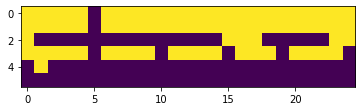

In [87]:
TF =pv>0.05 #True이면 통계적 유의성 부족. (설명력 x)
plt.imshow(TF.values)

In [88]:
pd.concat(se, axis=1)

0         1         2         3         4         5   \
Intercept  0.353330  0.210389  0.170404  0.192963  0.196965  0.165455   
market     1.922995  1.145038  0.927422  1.050195  1.071977  0.900485   
factor0    0.303387  0.180651  0.146318  0.165687  0.169124  0.142068   
factor1    0.290573  0.173020  0.140138  0.158689  0.161980  0.136067   
factor2    0.432502  0.257531  0.208587  0.236200  0.241099  0.202529   
factor3    0.474956  0.282810  0.229062  0.259385  0.264765  0.222408   

                 6         7         8         9         10        11  \
Intercept  0.163990  0.154126  0.143150  0.142627  0.160430  0.150591   
market     0.892515  0.838828  0.779089  0.776247  0.873138  0.819587   
factor0    0.140811  0.132340  0.122916  0.122467  0.137753  0.129305   
factor1    0.134863  0.126751  0.117724  0.117294  0.131935  0.123843   
factor2    0.200736  0.188661  0.175225  0.174586  0.196378  0.184334   
factor3    0.220440  0.207180  0.192425  0.191723  0.215654  0.202428   

                 12        13        14        15        16        17  \
Intercept  0.167030  0.135819  0.150379  0.157174  0.143858  0.141143   
market     0.909058  0.739193  0.818437  0.855417  0.782947  0.768169   
factor0    0.143420  0.116621  0.129123  0.134958  0.123524  0.121193   
factor1    0.137363  0.111695  0.123669  0.129257  0.118307  0.116074   
factor2    0.204457  0.166252  0.184075  0.192392  0.176093  0.172769   
factor3    0.224526  0.182572  0.202144  0.211277  0.193378  0.189728   

                 18        19        20        21        22        23  \
Intercept  0.149458  0.157774  0.163025  0.210299  0.185434  0.215159   
market     0.813422  0.858681  0.887260  1.144547  1.009220  1.170998   
factor0    0.128332  0.135473  0.139981  0.180573  0.159223  0.184746   
factor1    0.122912  0.129750  0.134069  0.172946  0.152497  0.176943   
factor2    0.182947  0.193126  0.199554  0.257421  0.226984  0.263370   
factor3    0.200905  0.212084  0.219142  0.282689  0.249265  0.289222   

                 24  
Intercept  0.200804  
market     1.092875  
factor0    0.172421  
factor1    0.165138  
factor2    0.245799  
factor3    0.269926

In [89]:
r

[0.1559557187776378,
 0.4432960385640754,
 0.5553873250614066,
 0.4691222696485694,
 0.43873655215422136,
 0.6730734988569962,
 0.6417079144603042,
 0.6368215378864158,
 0.615763639992857,
 0.6551788416182562,
 0.6876333165794117,
 0.6457071206198932,
 0.558601675586559,
 0.6267555870858779,
 0.5684023946347297,
 0.5838645816770855,
 0.5551929330340959,
 0.5338193879428773,
 0.45876692940043284,
 0.4758550770746266,
 0.5192034590713595,
 0.27014590182949516,
 0.2900217370889323,
 0.17004234147315678,
 0.21656253560013183]

#### 4. 블룸버그 데이터와의 비교 (우리 데이터가 괜찮음을 증명)

In [120]:
def get_item_for_period(item, date_from, date_to, term = 'Y', bloomberg=False, preprocess=[]):
    # term은 Y, H, Q의 세 가지 옵션으로, 연도별, 반기별, 분기별 데이터를 얻어올 수 있도록 하는 옵션이다.
    if bloomberg==False:
        data = []
        item_data = get_item(item)
        if term == 'Y':
            num = int(date_to[:4]) - int(date_from[:4]) +1
            date_working = date_from
            for i in range(num):
                data.append(item_data[date_working])
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) + date_working[4:]

        elif term == 'H':
            num = int((int(date_to[:4]) - int(date_from[:4])) * 2 + (int(date_to[4:6]) - int(date_from[4:6]))/6 + 1)
            date_working = date_from
            for i in range(num):
                try:
                    data.append(item_data[date_working])
                except:
                    try:
                        date_working = date_working[:6] + str(61 - int(date_working[6:]))
                        data.append(item_data[date_working])
                    except KeyError:
                        print('해당 날짜의 데이터가 없습니다:', date_working)
                if int(date_working[4:6])+6 > 12:
                    date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0'+ str(int(date_working[4:6])-6)+'31'
                else:
                    date_working = date_working[:4] + str(int(date_working[4:6]) + 6).zfill(2) + '31'

        else:
            num = int((int(date_to[:4]) - int(date_from[:4])) * 4 + (int(date_to[4:6]) - int(date_from[4:6]))/3 + 1)
            date_working = date_from
            for i in range(num):
                try:
                    data.append(item_data[date_working])
                except:
                    try:
                        date_working = date_working[:6] + str(61 - int(date_working[6:]))
                        data.append(item_data[date_working])
                    except KeyError:
                        print('해당 날짜의 데이터가 없습니다:', date_working)
                if int(date_working[4:6])+3 > 12:
                    date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0331'
                else:
                    date_working = date_working[:4] + str(int(date_working[4:6]) + 3).zfill(2) + '31'

        data = pd.concat(data, axis = 1)
        return data
    else:
        data = []
        item_data = bloomberg_get_item(preprocess, item)
        if term == 'Y':
            num = int(date_to[:4]) - int(date_from[:4]) +1
            date_working = date_from
            for i in range(num):
                data.append(item_data[date_working])
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) + date_working[4:]

        elif term == 'H':
            num = int((int(date_to[:4]) - int(date_from[:4])) * 2 + (int(date_to[4:6]) - int(date_from[4:6]))/6 + 1)
            date_working = date_from
            for i in range(num):
                try:
                    data.append(item_data[date_working])
                except:
                    try:
                        date_working = date_working[:6] + str(61 - int(date_working[6:]))
                        data.append(item_data[date_working])
                    except KeyError:
                        print('해당 날짜의 데이터가 없습니다:', date_working)
                if int(date_working[4:6])+6 > 12:
                    date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0'+ str(int(date_working[4:6])-6)+'31'
                else:
                    date_working = date_working[:4] + str(int(date_working[4:6]) + 6).zfill(2) + '31'

        else:
            num = int((int(date_to[:4]) - int(date_from[:4])) * 4 + (int(date_to[4:6]) - int(date_from[4:6]))/3 + 1)
            date_working = date_from
            for i in range(num):
                try:
                    data.append(item_data[date_working])
                except:
                    try:
                        date_working = date_working[:6] + str(61 - int(date_working[6:]))
                        data.append(item_data[date_working])
                    except KeyError:
                        print('해당 날짜의 데이터가 없습니다:', date_working)
                if int(date_working[4:6])+3 > 12:
                    date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0331'
                else:
                    date_working = date_working[:4] + str(int(date_working[4:6]) + 3).zfill(2) + '31'

        data = pd.concat(data, axis = 1)
        return data

def preprocessing_bloomberg(data, number_of_series, name_of_series):
    temp = data.index.map(lambda x: x[:4]+x[5:7]+x[8:10] if type(x)!=type(np.NaN) else x)
    data.index = list(map(lambda x: shift_q(x) if type(x)!=type(np.NaN) else x, temp))
    preprocess = dict()
    for i in tqdm.tqdm(range(number_of_series)):
        finance = data.iloc[:,i::number_of_series]
        finance.columns = list(map(lambda x: x[:6], finance.columns))
        real = finance.T.groupby(level=0, axis=1).last()
        preprocess[str(name_of_series[i])]=real
    return preprocess

def bloomberg_get_item(preprocess, concept_id): #preprocess는 list이고 리스트의 각 element는 item이름이 key, 데이터프레임이 value인 dict임)
    if len(preprocess)>1:
        temp = []
        for x in preprocess:
            temp.append(x[concept_id])
        datapool = pd.concat(temp)
    else:
        datapool = preprocess[0][concept_id]
    return datapool

def bloomberg_get_item_on_date(preprocess, item, date):
    return bloomberg_get_item(preprocess, item)[date]

In [121]:
#블룸버그 데이터 import
os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수\\data from bloomberg')
final = pd.read_csv('ff5 final.csv', encoding='cp949', header=1, index_col=0).iloc[1:,:]
final_preprocess = preprocessing_bloomberg(final, 6, ['equity', 'interest expense', 'total asset', 'operation incomeloss', 'net income', 'mktcap'])

C:\Users\jky93\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

  0%|          | 0/6 [00:00<?, ?it/s]

In [122]:
mktcap_for_SMB = get_item_for_period('mktcap', '20110630', '20200630', 'Y', True, [final_preprocess])
mktcap_for_HML = shift_date_quarter(get_item_for_period('mktcap', '20101231', '20191231', 'Y', True, [final_preprocess]),2)
equity = shift_date_quarter(get_item_for_period('equity', '20101231', '20191231', 'Y', True, [final_preprocess]), 2)
mktcap_for_HML = mktcap_for_HML.applymap(lambda x: float(x) if type(x)!=type(None) else x)
mktcap_for_SMB = mktcap_for_SMB.applymap(lambda x: float(x) if type(x)!=type(None) else x)
equity = equity.applymap(lambda x: float(x) if type(x)!=type(None) else x)

HML_standard = equity / mktcap_for_HML
SMB_standard = mktcap_for_SMB

In [141]:
os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수\\data from bloomberg')
kospi_data = pd.read_csv('kospi mktcap.csv', encoding='cp949', index_col=0).iloc[1:,:]
kosdaq_data = pd.read_csv('kosdaq mktcap.csv', encoding='cp949', index_col=0).iloc[1:,:]
kospi_data2 = preprocessing_bloomberg(kosdaq_data, 1, ['kosdaq_data'])['kosdaq_data'].loc[:, SMB_standard.columns[0]:].applymap(lambda x: float(x) if type(x)!=type(None) else x)
kosdaq_data2 = preprocessing_bloomberg(kospi_data,  1, ['kosdaq_data'])['kosdaq_data'].loc[:, SMB_standard.columns[0]:].applymap(lambda x: float(x) if type(x)!=type(None) else x)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [163]:
def bloomberg_get_market_category(division):
    os.chdir('C:\\Users\\jky93\\KYdrive\\바탕 화면\\SKKU\\7학기\\프로젝트 with 건수\\data from bloomberg')
    kospi_data = pd.read_csv('kospi mktcap.csv', encoding='cp949', index_col=0).iloc[1:,:]
    kosdaq_data = pd.read_csv('kosdaq mktcap.csv', encoding='cp949', index_col=0).iloc[1:,:]
    kospi_data2 = preprocessing_bloomberg(kosdaq_data, 1, ['kosdaq_data'])['kosdaq_data'].loc[:, division.columns[0]:].applymap(lambda x: float(x) if type(x)!=type(None) else x)
    kosdaq_data2 = preprocessing_bloomberg(kospi_data,  1, ['kosdaq_data'])['kosdaq_data'].loc[:, division.columns[0]:].applymap(lambda x: float(x) if type(x)!=type(None) else x)
    answersheet = SMB_standard * kospi_data2.iloc[:,::4]
    category = division.applymap(lambda x: whether_kospi(x, answersheet))
    return category
    
def whether_kospi(element, answersheet):
    if type(element)!= type(np.NaN):
        for i in tqdm.tqdm(range(answersheet.shape[0])):
            for j in range(answersheet.shape[1]):
                if type(answersheet) != type(np.NaN):
                    return 'KOSPI'
                else:
                    return 'KOSDAQ'
    else:
        print(type(element))
        return np.NaN

In [164]:
SMB_standard.applymap(lambda x: whether_kospi(x, answersheet))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

20110630  20120630  20130630  20140630  20150630  20160630  20170630  \
006840       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
035150       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
033250       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
010820       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
035000       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
003010       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
051630       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
037710       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
084870       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
000180       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
281820       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
002920       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
145270       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
039490       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
072130       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
069730       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
018250       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
161000       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
047050       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
047040       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
036460       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
024110       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
036570       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
003650       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
210980       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
031430       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
015360       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
079980       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
145720       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
396690       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
023150       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
005750       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
010600       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
023450       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
000210       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
377190       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
012030       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
011170       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
011760       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
012330       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
005320       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
015760       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
005090       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
357120       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
004000       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
010130       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
016880       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
003490       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
140910       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
395400  

In [155]:
answersheet = SMB_standard * kospi_data2.iloc[:,::4]

In [123]:
SMB_standard

20110630      20120630      20130630      20140630      20150630  \
006840  2.934000e+11  2.429700e+11  3.062380e+11  7.675740e+11  1.033310e+12   
035150  1.064800e+11  6.957500e+10  1.490720e+11  1.466520e+11  1.362460e+11   
033250  2.455394e+10  2.621299e+10  2.513464e+10  2.040635e+10  1.982568e+10   
010820  9.914138e+10  8.464429e+10  8.417671e+10  8.815172e+10  1.741990e+11   
035000  1.640170e+11  1.151430e+11  1.365150e+11  1.335330e+11  1.747860e+11   
003010  8.613366e+10  4.872207e+10  5.033794e+10  4.665578e+10  4.335047e+10   
051630  1.290000e+10  2.028000e+10  2.298000e+10  4.020000e+10  5.082000e+10   
037710  2.936000e+11  3.296000e+11  4.280000e+11  3.968000e+11  5.120000e+11   
084870  5.078630e+11  2.273390e+11  3.410090e+11  4.880500e+11  3.201520e+11   
000180  7.680000e+10  1.191000e+11  1.299410e+11  1.233000e+11  1.972220e+11   
281820           NaN           NaN           NaN           NaN           NaN   
002920  8.747340e+10  7.916732e+10  1.135200e+11  1.499770e+11  1.181910e+11   
145270           NaN  2.051849e+10  2.203637e+10  2.607501e+10  3.100812e+10   
039490  1.239790e+12  1.348080e+12  1.222120e+12  9.248740e+11  1.633170e+12   
072130  4.011432e+10  6.967171e+10  7.983249e+10  5.588275e+10  6.861636e+10   
069730  6.105600e+10  4.795200e+10  3.866400e+10  5.796000e+10  4.888800e+10   
018250           NaN           NaN           NaN           NaN           NaN   
161000           NaN           NaN  1.845500e+11  2.306880e+11  2.294060e+11   
047050  3.902130e+12  3.416480e+12  4.025530e+12  4.167870e+12  2.938010e+12   
047040  4.447160e+12  3.640850e+12  2.946760e+12  3.645010e+12  2.568550e+12   
036460  2.859530e+12  3.130020e+12  4.080620e+12  5.095680e+12  3.987920e+12   
024110  1.018290e+13  6.961520e+12  6.024640e+12  7.458950e+12  8.040010e+12   
036570  6.351450e+12  5.976430e+12  3.550180e+12  4.002050e+12  4.352910e+12   
003650  8.246178e+10  7.898238e+10  1.426530e+11  1.243870e+11  1.336070e+11   
210980           NaN           NaN           NaN           NaN  6.168750e+11   
031430           NaN  6.204660e+11  5.733420e+11  6.033300e+11  9.496200e+11   
015360  1.440000e+11  1.500000e+11  2.148000e+11  2.256000e+11  2.220000e+11   
079980           NaN  3.381000e+11  3.484500e+11  3.933000e+11  3.743250e+11   
145720           NaN           NaN           NaN           NaN           NaN   
396690           NaN           NaN           NaN           NaN           NaN   
023150  2.019500e+10  2.380000e+10  2.373000e+10  5.019236e+10  1.058820e+11   
005750  2.737500e+10  6.390000e+10  2.580000e+10  5.805000e+10  2.519020e+11   
010600  1.293560e+10  1.983285e+10  1.476250e+10  2.943606e+10  3.408349e+10   
023450  2.224242e+10  6.672726e+10  4.857628e+10  4.116200e+10  5.394707e+10   
000210  4.471800e+12  3.138960e+12  3.020640e+12  2.933640e+12  2.853600e+12   
377190           NaN           NaN           NaN           NaN           NaN   
012030  1.384160e+11  1.202030e+11  9.962309e+10  4.088736e+10  1.050870e+11   
011170  1.260060e+13  7.534890e+12  4.901380e+12  6.323810e+12  9.905600e+12   
011760  7.078550e+11  4.789740e+11  4.934890e+11  7.871260e+11  8.016400e+11   
012330  3.893760e+13  2.672090e+13  2.657490e+13  2.764570e+13  2.063690e+13   
005320  6.675251e+09  6.334378e+09  8.790039e+09  4.493194e+10  6.457171e+10   
015760  1.819970e+13  1.646640e+13  1.701200e+13  2.394530e+13  2.940200e+13   
005090  3.344680e+11  2.747590e+11  2.927210e+11  2.288860e+11  5.631120e+11   
357120           NaN           NaN           NaN           NaN           NaN   
004000  1.767300e+12  1.542840e+12  1.093920e+12  1.061670e+12  8.939700e+11   
010130  7.727270e+12  7.264950e+12  5.226990e+12  7.491390e+12  1.028420e+13   
016880  4.563060e+11  3.429510e+11  1.381380e+11  1.313170e+11  1.334890e+11   
003490  5.016420e+12  3.620170e+12  2.240210e+12  1.959760e+12  2.950010e+12   
140910           NaN  1.661945e+10  1.560356e+10  1.329931e+10  1.970403e+10   
395400      

In [146]:
kospi_data2.iloc[:,::4]

20110630      20120630      20130630      20140630      20150630  \
045510  7.978692e+09  1.361633e+10  3.047844e+10  1.844539e+10  3.140203e+10   
121850           NaN           NaN  5.650965e+10  2.894237e+10  3.191023e+10   
290380           NaN           NaN           NaN           NaN           NaN   
042510  9.215385e+09  5.074128e+09  3.818959e+10  4.981180e+10  9.781456e+10   
049480  1.857535e+10  5.006999e+10  5.563329e+10  4.945182e+10  5.341805e+10   
024850  3.556944e+10  1.468948e+10  1.794983e+10  1.361808e+10  5.644147e+10   
036540  3.338490e+11  2.589380e+11  2.178760e+11  1.765440e+11  2.026630e+11   
050110  4.312238e+10  6.010420e+10  1.104610e+11  1.102520e+11  8.722506e+10   
045390  1.528730e+11  1.028550e+11  1.014460e+11  1.090180e+11  1.001690e+11   
045660  3.801200e+10  3.984800e+10  5.916000e+10  5.535200e+10  8.364000e+10   
148250           NaN           NaN           NaN  1.646911e+10  3.150613e+10   
052190  3.788100e+10  6.893100e+10  7.886700e+10  8.228250e+10  6.644700e+10   
051780  4.211379e+10  7.356564e+10  3.323568e+10  2.448847e+10  4.552262e+10   
033790  2.270869e+10  2.202400e+10  2.213812e+10  2.333631e+10  2.099698e+10   
216050           NaN           NaN           NaN           NaN           NaN   
043220  1.439316e+10  1.456094e+10  1.077714e+10  2.232767e+10  5.293873e+10   
052600  2.856234e+10  2.445722e+10  2.353213e+10  2.653869e+10  3.526928e+10   
273060           NaN           NaN           NaN           NaN           NaN   
052330  1.119300e+11  1.345310e+11  1.804050e+11  1.550970e+11  1.998730e+11   
049120  2.676640e+10  4.130690e+10  1.857617e+10  2.631160e+10  3.053666e+10   
036890  1.456000e+11  1.989000e+11  1.060000e+11  1.448000e+11  1.340000e+11   
043360  2.466000e+10  3.150000e+10  2.250000e+10  2.520000e+10  3.114000e+10   
051980  2.221785e+10  3.159496e+10  3.388643e+10  2.306234e+10  3.523925e+10   
049520  3.121545e+10  2.990531e+10  1.201910e+11  1.139250e+11  1.401270e+11   
053610  6.190824e+10  7.410914e+10  8.370000e+10  7.551000e+10  7.668000e+10   
053800  1.907650e+11  1.112540e+12  5.107070e+11  4.240870e+11  5.157140e+11   
123010           NaN           NaN           NaN           NaN  1.455818e+10   
040300  1.050000e+11  1.623300e+11  1.150800e+11  1.249500e+11  1.129800e+11   
049470  1.355805e+10  3.764804e+10  3.820188e+10  3.603590e+10  6.998603e+10   
054800  1.763520e+11  9.716584e+10  1.427990e+11  1.495250e+11  1.717730e+11   
053110  3.550622e+10  1.136100e+11  4.794555e+10  8.914667e+10  1.648530e+11   
052400  1.045160e+11  1.673430e+11  4.020870e+11  3.898900e+11  5.134510e+11   
054920  1.420800e+10  3.102080e+10  3.338880e+10  4.274240e+10  3.504640e+10   
051390  5.524402e+10  5.632278e+10  5.950213e+10  5.836659e+10  4.298007e+10   
053350  3.615453e+10  7.085142e+10  8.559571e+10  8.609049e+10  1.258700e+11   
043260  4.899179e+10  4.189866e+10  3.717774e+10  3.776786e+10  2.758824e+10   
054620  2.886210e+11  2.897090e+11  2.564110e+11  1.795540e+11  2.123280e+11   
054940  3.863818e+10  2.968231e+10  2.346440e+10  2.951759e+10  9.222247e+10   
045300  1.120168e+10  1.790494e+10  2.020908e+10  1.580202e+10  2.289883e+10   
058470  1.805020e+11  1.925350e+11  3.345700e+11  4.786100e+11  7.758370e+11   
043590  3.939000e+10  7.293000e+10  5.895500e+10  4.153500e+10  4.894500e+10   
056360  1.542996e+10  2.160194e+10  3.850142e+10  4.482036e+10  5.858486e+10   
056730  5.592197e+10  4.369496e+10  2.125249e+10  1.496008e+10  3.023240e+10   
060250  5.071794e+10  9.909675e+10  1.644440e+11  1.390450e+11  5.964500e+11   
187420           NaN           NaN           NaN           NaN  3.410780e+11   
042500  1.865427e+10  4.435746e+10  3.893497e+10  6.656951e+10  6.141076e+10   
050320  7.392353e+09  1.816513e+10  1.121855e+10  8.803958e+09  3.053525e+10   
059090  6.444230e+10  4.662801e+10  5.380154e+10  4.351947e+10  7.317761e+10   
041510  3.903680e+11  9.876360e+11  6.979110e+11  7.443700e+11  6.648740e+11   
047080  5.13

In [147]:
kosdaq_data2.iloc[:,::4]

20110630      20120630      20130630      20140630      20150630  \
006840  2.934000e+11  2.429700e+11  3.062380e+11  7.675740e+11  1.033310e+12   
035150  1.064800e+11  6.957500e+10  1.490720e+11  1.466520e+11  1.362460e+11   
033250  2.455394e+10  2.621299e+10  2.513464e+10  2.040635e+10  1.982568e+10   
010820  9.914138e+10  8.464429e+10  8.417671e+10  8.815172e+10  1.741990e+11   
035000  1.640170e+11  1.151430e+11  1.365150e+11  1.335330e+11  1.747860e+11   
003010  8.613366e+10  4.872207e+10  5.033794e+10  4.665578e+10  4.335047e+10   
051630  1.290000e+10  2.028000e+10  2.298000e+10  4.020000e+10  5.082000e+10   
037710  2.936000e+11  3.296000e+11  4.280000e+11  3.968000e+11  5.120000e+11   
084870  5.078630e+11  2.273390e+11  3.410090e+11  4.880500e+11  3.201520e+11   
000180  7.680000e+10  1.191000e+11  1.299410e+11  1.233000e+11  1.972220e+11   
281820           NaN           NaN           NaN           NaN           NaN   
002920  8.747340e+10  7.916732e+10  1.135200e+11  1.499770e+11  1.181910e+11   
145270           NaN  2.051849e+10  2.203637e+10  2.607501e+10  3.100812e+10   
039490  1.239790e+12  1.348080e+12  1.222120e+12  9.248740e+11  1.633170e+12   
072130  4.011432e+10  6.967171e+10  7.983249e+10  5.588275e+10  6.861636e+10   
069730  6.105600e+10  4.795200e+10  3.866400e+10  5.796000e+10  4.888800e+10   
018250           NaN           NaN           NaN           NaN           NaN   
161000           NaN           NaN  1.845500e+11  2.306880e+11  2.294060e+11   
047050  3.902130e+12  3.416480e+12  4.025530e+12  4.167870e+12  2.938010e+12   
047040  4.447160e+12  3.640850e+12  2.946760e+12  3.645010e+12  2.568550e+12   
036460  2.859530e+12  3.130020e+12  4.080620e+12  5.095680e+12  3.987920e+12   
024110  1.018290e+13  6.961520e+12  6.024640e+12  7.458950e+12  8.040010e+12   
036570  6.351450e+12  5.976430e+12  3.550180e+12  4.002050e+12  4.352910e+12   
003650  8.246178e+10  7.898238e+10  1.426530e+11  1.243870e+11  1.336070e+11   
210980           NaN           NaN           NaN           NaN  6.168750e+11   
031430           NaN  6.204660e+11  5.733420e+11  6.033300e+11  9.496200e+11   
015360  1.440000e+11  1.500000e+11  2.148000e+11  2.256000e+11  2.220000e+11   
079980           NaN  3.381000e+11  3.484500e+11  3.933000e+11  3.743250e+11   
145720           NaN           NaN           NaN           NaN           NaN   
396690           NaN           NaN           NaN           NaN           NaN   
023150  2.019500e+10  2.380000e+10  2.373000e+10  5.019236e+10  1.058820e+11   
005750  2.737500e+10  6.390000e+10  2.580000e+10  5.805000e+10  2.519020e+11   
010600  1.293560e+10  1.983285e+10  1.476250e+10  2.943606e+10  3.408349e+10   
023450  2.224242e+10  6.672726e+10  4.857628e+10  4.116200e+10  5.394707e+10   
000210  4.471800e+12  3.138960e+12  3.020640e+12  2.933640e+12  2.853600e+12   
377190           NaN           NaN           NaN           NaN           NaN   
012030  1.384160e+11  1.202030e+11  9.962309e+10  4.088736e+10  1.050870e+11   
011170  1.260060e+13  7.534890e+12  4.901380e+12  6.323810e+12  9.905600e+12   
011760  7.078550e+11  4.789740e+11  4.934890e+11  7.871260e+11  8.016400e+11   
012330  3.893760e+13  2.672090e+13  2.657490e+13  2.764570e+13  2.063690e+13   
005320  6.675251e+09  6.334378e+09  8.790039e+09  4.493194e+10  6.457171e+10   
015760  1.819970e+13  1.646640e+13  1.701200e+13  2.394530e+13  2.940200e+13   
005090  3.344680e+11  2.747590e+11  2.927210e+11  2.288860e+11  5.631120e+11   
357120           NaN           NaN           NaN           NaN           NaN   
004000  1.767300e+12  1.542840e+12  1.093920e+12  1.061670e+12  8.939700e+11   
010130  7.727270e+12  7.264950e+12  5.226990e+12  7.491390e+12  1.028420e+13   
016880  4.563060e+11  3.429510e+11  1.381380e+11  1.313170e+11  1.334890e+11   
003490  5.016420e+12  3.620170e+12  2.240210e+12  1.959760e+12  2.950010e+12   
140910           NaN  1.661945e+10  1.560356e+10  1.329931e+10  1.970403e+10   
395400      

In [118]:
get_market_category(RMW_base_shifted)

20110630 20120630 20130630 20140630 20150630 20160630 20170630  \
corp_code                                                                  
069110      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
060310      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
900010      KOSDAQ   KOSDAQ      NaN      NaN      NaN      NaN      NaN   
038120      KOSDAQ   KOSDAQ      NaN      NaN      NaN      NaN      NaN   
013340      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ      NaN      NaN      NaN   
054620      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
138930       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
048550      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
001460       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
001465       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
032040      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
001040       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
079160       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
130960      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
011150       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
011155       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
035760      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
001045       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
097950       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
097955       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
051500      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
023460      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
065770      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
000590       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
050470      KOSDAQ      NaN      NaN      NaN      NaN      NaN      NaN   
056340      KOSDAQ   KOSDAQ   KOSDAQ      NaN      NaN      NaN      NaN   
139130       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
068790      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
069730       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
009730      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
017940       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
037370      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
080220      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
079190      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
007700       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
114090       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
078930       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
083450      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
006360       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
001250       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
078935       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
028150      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
053870      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ      NaN      NaN   
035000       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
032800      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
041590      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
126640      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
001500       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    KOSPI   
036640      KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   KOSDAQ   
126680      KOSDAQ   KOSDAQ   KOSDAQ      NaN      NaN      NaN      NaN   
011420       KOSPI    KOSPI    KOSPI    KOSPI    KOSPI    